<a href="https://colab.research.google.com/github/msbeigi/NLP-analysis/blob/main/sentence_classification/transformers/Copy_of_sentence_level_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **requirements**

In [ ]:
!pip install --upgrade tensorflow==2.14  # TPU ONLY
!pip install --upgrade transformers==4.30

# !pip install transformers[torch,accelerate]
# !pip install transformers[torch,accelerate]
!pip install accelerate==0.20.1
!pip install spacy ftfy==4.4.3
!python -m spacy download en
!pip install --upgrade sentencepiece
!pip install --upgrade ray
!pip install lime
!pip install shap
!pip install argilla #
!pip install transformers-interpret==0.5.2
!pip install bertviz
!pip install xformers
!pip install snowflake

import warnings

warnings.filterwarnings("ignore")


## Libraries

In [1]:
from transformers import pipeline
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import XLNetForSequenceClassification, XLNetTokenizer
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
from transformers import AutoModelForSequenceClassification, XLNetTokenizer
import torch
import time
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F
import shap, lime
# import torch
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel
from torch.utils.data import DataLoader
import ast

#
from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
from transformers import BertTokenizerFast
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizerFast, BertForSequenceClassification
# from transformers import Trainer, TrainingArguments
# from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from ray import tune
# data storage

import snowflake.snowpark as snowpark
from snowflake.snowpark.functions import col
from snowflake.snowpark.types import StructField, StructType, IntegerType, StringType, VariantType
from snowflake.snowpark.session import Session
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import getpass
import pandas as pd
import json
import os



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mounted at /content/drive


## **Data storage snowflake**

In [2]:
d = {
    "user": "msbeigi",
    "password": "Ghi9rail755",
    "account": "xcyevyt-po65493",
    "warehouse": "COMPUTE_WH",
    "database": "GIT",
    "schema": "PUBLIC",
    "role": "ACCOUNTADMIN"
}
# stor = setup(conf_path='',conn_spec=d)

### Data storage

#### class Data_storage

In [3]:

class Data_storage():

  def __init__(self,conf_path:str='' ,conn_spec:dict =None):
      """
      Reads Snowflake connection details from config.json file.

      Returns:
          dict: Configuration details for Snowflake connection.
      """
      self.CONFIG={}

      keys = ['user', 'password', 'account', 'warehouse', 'database', 'schema', 'role']
      # CONFIG = {}
      if conf_path and conf_path.strip():
        with open(conf_path) as f:
            config_data=json.load(f)
        snowflake_config=config_data.get('snowflake',{})

        for key in keys:
            self.CONFIG[key] = snowflake_config.get(key)
      elif conn_spec and not conf_path:
        for key,val in conn_spec.items():
          self.CONFIG[key]=conn_spec[key]

      # return self.CONFIG#snowflake_config.get('user')

  def connector(self):
      """
      Establishes a connection to Snowflake using the configuration details.

      Returns:
          snowflake.connector.connection.SnowflakeConnection: Snowflake connection object.
      """
        # con= None
      # try:
      con = snowflake.connector.connect(
      user=self.CONFIG['user'],
      password=self.CONFIG['password'],
      account=self.CONFIG['account'],
      warehouse=self.CONFIG['warehouse'],
      database=self.CONFIG['database'],
      schema=self.CONFIG['schema'],
      role=self.CONFIG['role']
      )
      # except Exception as e:
      #   print(f"An error occurred: {e}")

      return con

  def create_table_edos(self):
      """
          Creates a table 'Odes_Comments' in Snowflake if it does not exist.

          Returns:
              None
          """
      try:
        con=self.connector()
        cur=con.cursor()

        table_exists_query = f"SELECT COUNT(*) FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = '{self.CONFIG['schema']}' AND TABLE_NAME = 'tbl_Odes_Comments'"
        cur.execute(table_exists_query)
        table_exists = cur.fetchone()[0]

        if table_exists == 0:
            create_command='CREATE TABLE "tbl_Odes_Comments" (     \
                                              "rewire_id" VARCHAR,    \
                                              "text" VARCHAR,    \
                                              "label_sexist" VARCHAR,\
                                              "label_category" VARCHAR,\
                                              "label_vector" VARCHAR,    \
                                              "split" VARCHAR,    \
                                              "token" VARCHAR,    \
                                              "target" VARCHAR,    \
                                              "keyword" VARCHAR,    \
                                              "bert_predicted_class" INTEGER,    \
                                              "reberta_predicted_class" INTEGER,    \
                                              "xlnet_predicted_class" INTEGER,    \
                                              "lime_output_token" VARCHAR,    \
                                              "lime_class0_predict_token" DOUBLE,    \
                                              "lime_class1_predict_token" DOUBLE,    \
                                              "SHAP_value_token" VARCHAR,    \
                                              "SHAP_class0_prediction_token" DOUBLE,    \
                                              "SHAP_class1_prediction_token" DOUBLE,    \
                                              "lime_output_target" VARCHAR,    \
                                              "lime_class0_predict_target" DOUBLE,    \
                                              "lime_class1_predict_target" DOUBLE,    \
                                              "SHAP_value_target" VARCHAR,    \
                                              "SHAP_class0_prediction_target" DOUBLE,    \
                                              "SHAP_class1_prediction_target" DOUBLE    \
                                          );'


            cur.execute(create_command)
            print("Table 'Odes_Comments' created.")
        else:
            print("Table 'Odes_Comments' exists.")
        return True

      except Exception as e:
        print(f"An error occurred: {e}")
        return False

      finally:
        cur.close()
        con.close()

  def load_csv_file(self):
      """
      Loads a CSV file 'sample_comments.csv' from the data directory.

      Returns:
          pandas.DataFrame: DataFrame containing the loaded data.
      """
      file_path = './data/sample_comments.csv'
      df = pd.read_csv(file_path)

      return df

  def read_table(self,table):
    try:
      conn=self.connector()
      # Create a cursor
      cur = conn.cursor()

      # Execute a query to fetch data from the table
      query = f'SELECT * FROM GIT.PUBLIC."{table}"'
      cur.execute(query)

      # Fetch all rows
      rows = cur.fetchall()

      # Get the column names from the cursor description
      columns = [desc[0] for desc in cur.description]

      # Create a DataFrame from the fetched rows and column names
      df = pd.DataFrame(rows, columns=columns)

      # Close the cursor and connection

    except Exception as e:
      print(f"An error occurred: {e}")
      return None

    finally:
      cur.close()
      conn.close()
      return df

  def insert_file_odes(self):
      """
      Inserts data from the CSV file into the 'Odes_Comments' table in Snowflake.

      Returns:
          None
      """
      # try:
      df_comments=self.load_csv_file()
      conn=self.connector()
      cur=conn.cursor()

      select_command='SELECT * FROM GIT.PUBLIC."tbl_Odes_Comments"'
      cur.execute(select_command)
      data=cur.fetchall()

      if not data:
          # print(len(pd.DataFrame(data)))
          write_pandas(conn,df_comments,table_name='tbl_Odes_Comments')
      else:
          print('Data already in the table.')
        # return True

      # except Exception as e:
      #   print(f"An error occurred: {e}")
      #   return False
      # finally:
      cur.close()
      conn.close()

  def insert_odes_dataframe(self,df_comments:pd.DataFrame):
      """
      Inserts data from DataFrame into the 'tbl_Odes_Comments' table in Snowflake.

      Returns:
          Boolean
      """
      # try:
      conn=self.connector()
      cur=conn.cursor()

      select_command='SELECT * FROM GIT.PUBLIC."tbl_Odes_Comments"'
      cur.execute(select_command)
      data=cur.fetchall()

      if not data:
          # print(len(pd.DataFrame(data)))
          write_pandas(conn,df_comments,table_name='tbl_Odes_Comments')
      else:
          print('Data already in the table.')
      #   return True
      # except Exception as e:
      #   print(f"An error occurred: {e}")
      #   return False
      # finally:
      cur.close()
      conn.close()

  def update_columns(self,df_comments:pd.DataFrame,col_list:list[str]): #bool

    table_name = 'tbl_Odes_Comments'

    conn=self.connector()
    cur=conn.cursor()
    for key in col_list:
      # Iterate over the DataFrame and update each row in the database
      for index, row in df_comments.iterrows():
          rewire_id_value = row['rewire_id']
          predicted_class = row[key]

          # if not np.isnan(predicted_class):
          # if pd.notna(predicted_class).any():
          # Formulate the SQL update query
          update_query = f'UPDATE GIT.PUBLIC."{table_name}" SET "{key}" = {predicted_class} WHERE "rewire_id" = \'{rewire_id_value}\''

          # Execute the update query
          cur.execute(update_query)

      # Commit the changes
      conn.commit()

    # Close the cursor and connection
    cur.close()
    conn.close()

  def update_columns_ex(self,df_comments:pd.DataFrame,col_list:dict):

    table_name = 'tbl_Odes_Comments'

    conn=self.connector()
    cur=conn.cursor()
    try:
        for key,valu in col_list.items():
            # Iterate over the DataFrame and update each row in the database
            for index, row in df_comments.iterrows():
                rewire_id_value = row['rewire_id']
                # print(rewire_id_value)
                if valu=='json' :
                  predicted_class = str(row[key]).replace("'",'"')
                else:
                  predicted_class=row[key]
                # print(predicted_class)

                # Check if predicted_class is not None
                if pd.notna(predicted_class):#.any():
                    # If predicted_class is not None, construct the SQL update query
                    update_query = f'UPDATE GIT.PUBLIC."{table_name}" SET "{key}" = \'{predicted_class}\' WHERE "rewire_id" = \'{rewire_id_value}\''

                    # Execute the update query
                    cur.execute(update_query)
                    print('\n',update_query)

        # Commit the changes
        conn.commit()
        print('succefully updated!')

    except Exception as e:
      print(e,'\n',update_query)
    # Close the cursor and connection
    finally:
      cur.close()
      conn.close()


#### load data

In [170]:
db=Data_storage(conn_spec=d)
dt=db.read_table('tbl_Odes_Comments')
df=dt.copy()
dt.head(3)

rewire_id  \
0   sexism2022_english-9609   
1  sexism2022_english-16993   
2  sexism2022_english-13149   

                                                text label_sexist  \
0  in nigeria, if you rape a woman, the men rape ...   not sexist   
1                            then, she's a keeper. 😉   not sexist   
2  this is like the metallica video where the poo...   not sexist   

  label_category label_vector  split token target keyword  \
0           none         none    dev  none   none    None   
1           none         none  train  none   none    None   
2           none         none  train  none   none    None   

   bert_predicted_class  ...  lime_class1_predict_token SHAP_value_token  \
0                   NaN  ...                        NaN             None   
1                   NaN  ...                        NaN             None   
2                   NaN  ...                        NaN             None   

  SHAP_class0_prediction_token  SHAP_class1_prediction_token  \
0                          NaN                           NaN   
1                          NaN                           NaN   
2                          NaN                           NaN   

   lime_output_target lime_class0_predict_target  lime_class1_predict_target  \
0                None                        NaN                         NaN   
1                None                        NaN                         NaN   
2                None                        NaN                         NaN   

   SHAP_value_target SHAP_class0_prediction_target  \
0               None                           NaN   
1               None                           NaN   
2               None                           NaN   

   SHAP_class1_prediction_target  
0                            NaN  
1                            NaN  
2                            NaN  

[3 rows x 24 columns]

In [159]:
# predicted_class=0
# # conn=self.connector()
# cur=conn.cursor()
# update_query = f'UPDATE GIT.PUBLIC."tbl_Odes_Comments" SET "bert_predicted_class" = {predicted_class} WHERE "rewire_id" = \'sexism2022_english-845\''

# cur.execute(update_query)

# # Commit the changes
# conn.commit()

# # Close the cursor and connection
# cur.close()
# conn.close()



In [160]:
# def update_columns(conn,df_comments:pd.DataFrame,col_list:list[str]): #bool

#     table_name = 'tbl_Odes_Comments'

#     # conn=self.connector()
#     cur=conn.cursor()
#     for key in col_list:
#       # Iterate over the DataFrame and update each row in the database
#       for index, row in df_comments.iterrows():
#           rewire_id_value = row['rewire_id']
#           predicted_class = row[key]

#           if not np.isnan(predicted_class):
#             # Formulate the SQL update query
#             update_query = f'UPDATE GIT.PUBLIC."{table_name}" SET "{key}" = {predicted_class} WHERE "rewire_id" = \'{rewire_id_value}\''

#             # Execute the update query
#             cur.execute(update_query)

#       # Commit the changes
#       conn.commit()

#     # Close the cursor and connection
#     cur.close()
#     conn.close()



In [161]:
# df_test_=df_test.copy()

### **Data processing utilities**

In [8]:
def data_preparation(data ):
    # Encode the 'label_sexist' column to numerical values
    label_encoder = LabelEncoder()
    data['label'] = label_encoder.fit_transform(data['label_sexist'])

    # Extract tokens and targets based on provided information
    data['token'] = data['token'].fillna('none')
    data['target'] = data['target'].fillna('none')
    return data

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stopwords.words('english') and word.isalnum()]

    return ' '.join(tokens)

def remove_noises(text):
    # Convert to lowercase
    text = text.lower()
    noise_pattern = r'\[url\]|\[user\]|\[username\]|\#\w+'
    cleaned_text = re.sub(noise_pattern, '', text)

    return cleaned_text

def data_cleansing(data):
    data['text'] = data['text'].apply(remove_noises)

    return data

def data_preprocess(data):
    # data cleaning
    data = data_cleansing(data)

    # Apply preprocessing to the 'text' column
    # data['text_token'] = data['text'].apply(preprocess_text)
    data=data_preparation(data )
    return data

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


## **Data loading**

In [ ]:
# path="/content/drive/MyDrive/Uni/Aston/Dissertation/edos_labelled_aggregated.csv"
# def laod_data(path,separator=','):
#   df=pd.read_csv(path,sep=separator)


#   return df
# df=laod_data(path)#[:5000]

#### insert dataset

In [ ]:
# util_store=Data_storage(conn_spec=d)
# conn=util_store.connector()

# bol=util_store.create_table_edos()
# if(bol):
#   result=util_store.insert_odes_dataframe(df[['rewire_id',	'text',	'label_sexist',	'label_category',	'label_vector',	'split',	'token',	'target',	'keyword']])
#   if(result):
#     print('dataframe inserted.')

### EDA

In [ ]:

df.head(2)


In [ ]:
df.groupby(['split','label_sexist']).count()


In [ ]:

df.groupby(['split','label_sexist']).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.groupby('label_sexist').count()

In [ ]:

df.groupby('label_sexist').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['text']))

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## **Train test split**

In [171]:
data=data_preprocess(df)


### **Train test split (25%)**

In [172]:

def data_split_stratify(df):
  df_train= df[df['split']=='train']
  df_test=df[df['split']=='test']
  df_evaluate=df[df['split']=='dev']
  # df_test_filtered = df_test[df_test['token'].notna() & df_test['token'].applymap(lambda x: isinstance(x, str))]

  #
  X_tr,_,y_tr,_=train_test_split( df_train['text'],df_train['label'],test_size=0.75,stratify=df_train['label'])
  print(f'Total number of train:{len(df_train)} and number of train split:{len(X_tr)}')
  X_ts,_,y_ts,_=train_test_split( df_test[['text','token','target']],df_test['label'],test_size=0.75,stratify=df_test['label'])
  print(f'Total number of test:{len(df_test)} and number of test split:{len(X_ts)}')
  X_val,_,y_val,_=train_test_split( df_evaluate['text'],df_evaluate['label'],test_size=0.75,stratify=df_evaluate['label'])
  print(f'Total number of validation:{len(df_evaluate)} and number of validation split:{len(X_val)}')
  #
  df_eval=pd.concat([X_val,y_val],axis=1)
  df_tr=pd.concat([X_tr,y_tr],axis=1)
  df_ts=pd.concat([X_ts,y_ts],axis=1)

  return df_tr,df_eval,df_ts


df_train,df_evaluate,df_test_=data_split_stratify(data)
df_test=df_test_[['text','label']]



Total number of train:14000 and number of train split:3500
Total number of test:4000 and number of test split:1000
Total number of validation:2000 and number of validation split:500


###**Train test split all**

In [ ]:
def train_test(df):
  df_train=df[df['split']=='train']#[['rewire_id','label_sexist','text_token']]
  df_test=df[df['split']=='test']#[['rewire_id','label_sexist','text_token']]
  df_evaluate=df[df['split']=='dev']#[['rewire_id','label_sexist','text_token']]
  return df_train,df_evaluate,df_test

data=data_preprocess(df)

df_train,df_evaluate,df_test=train_test(data)

In [ ]:

df_evaluate.head(5)




rewire_id  \
0    sexism2022_english-9609   
4     sexism2022_english-966   
9    sexism2022_english-3553   
15  sexism2022_english-13328   
29     sexism2022_english-81   

                                                 text label_sexist  \
0   in nigeria, if you rape a woman, the men rape ...   not sexist   
4                      i bet she wished she had a gun   not sexist   
9   i agree with that but at the same time i know ...       sexist   
15  democrats from minnesota (leftist muzzie shith...       sexist   
29  texas jury sentences jordanian immigrant to de...   not sexist   

   label_category                        label_vector split  \
0            none                                none   dev   
4            none                                none   dev   
9   2. derogation             2.1 descriptive attacks   dev   
15  2. derogation  2.2 aggressive and emotive attacks   dev   
29           none                                none   dev   

                                                token  \
0                                                none   
4                                                none   
9   I can't love a woman,  she begins to hit the wall   
15  democrats are the dumbest anti-americans , Klo...   
29                                               none   

                          target                            keyword  \
0                           none                               None   
4                           none                               None   
9                         women                                None   
15  Klobuchar, this stupid woman  dumbest, dumb bitch, Fuck, stupid   
29                          none                               None   

    bert_predicted_class  ...  SHAP_value_token SHAP_class0_prediction_token  \
0                    NaN  ...              None                         None   
4                    NaN  ...              None                         None   
9                    NaN  ...              None                         None   
15                   NaN  ...              None                         None   
29                   NaN  ...              None                         None   

   SHAP_class1_prediction_token  lime_output_target  \
0                          None                None   
4                          None                None   
9                          None                None   
15                         None                None   
29                         None                None   

    lime_class0_predict_target lime_class1_predict_target SHAP_value_target  \
0                          NaN                        NaN              None   
4                          NaN                        NaN              None   
9                          NaN                        NaN              None   
15                         NaN                        NaN              None   
29                         NaN                        NaN              None   

   SHAP_class0_prediction_target SHAP_class1_prediction_target  label  
0                           None                          None      0  
4                           None                          None      0  
9                           None                          None      1  
15                          None                          None      1  
29                          None                          None      0  

[5 rows x 25 columns]

### **Data postprocessing**

In [ ]:
train_texts=df_train['text'].tolist()
train_labels = df_train['label'].astype(int).tolist()

valid_texts=df_evaluate['text'].tolist()
valid_labels = df_evaluate['label'].astype(int).tolist()



# **Modeling**

### **"bert-base-uncased" model**

#### Load "bert-base-uncased" model

In [ ]:
# model_name = "distilbert-base-uncased"
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# model = DistilBertForSequenceClassification.from_pretrained(model_name)

bert_model_name = "bert-base-uncased"
max_length = 255


tokenizer = BertTokenizerFast.from_pretrained(bert_model_name, do_lower_case=True)


####  Tokenize train and evaluation data

In [ ]:

  train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
  train_dataset = CustomDataset(train_encodings, train_labels)
  batch_size = 16
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  test_encodings = tokenizer(valid_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
  test_dataset = CustomDataset(test_encodings, valid_labels)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:

model=BertForSequenceClassification.from_pretrained(bert_model_name)
training_args = TrainingArguments(
   output_dir='/content/output',
   num_train_epochs=10,
   per_device_train_batch_size=16,  # batch size
   weight_decay=0.01,               # strength of weight decay
   load_best_model_at_end=True,
   logging_steps=200,
   evaluation_strategy="steps",
   save_steps=400,  # a multiple of evaluation_steps
   # no_deprecation_warning=True
)
###


#### Train "bert-base-uncased"

In [ ]:

trainer = Trainer( model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,)
trainer.train()



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=4640, training_loss=0.09902979127923729, metrics={'train_runtime': 4243.1258, 'train_samples_per_second': 17.485, 'train_steps_per_second': 1.094, 'total_flos': 3393161364349800.0, 'train_loss': 0.09902979127923729, 'epoch': 10.0})

#### Prediction by "bert-base-uncased"

In [ ]:

test_texts_2=df_test['text'].tolist()
test_labels_2 = df_test['label'].astype(int).tolist()


test_encodings_2 = tokenizer(test_texts_2, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
test_dataset_2 = CustomDataset(test_encodings_2, test_labels_2)

In [ ]:
predictions = trainer.predict(test_dataset_2).predictions
predicted_labels = predictions.argmax(axis=1)
f1_macro = f1_score(test_labels_2, predicted_labels, average='macro')

print("F1 Macro:", f1_macro)
print(classification_report(test_labels_2, predicted_labels))


F1 Macro: 0.7769499146022801
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1579
           1       0.84      0.53      0.65       563

    accuracy                           0.85      2142
   macro avg       0.85      0.75      0.78      2142
weighted avg       0.85      0.85      0.84      2142



#### Prediction of test data

In [ ]:
con_path = '/content/drive/MyDrive/ML/NLPResults/BERT_epoch10_batchsize16_rate5e-5'

bert_model = AutoModelForSequenceClassification.from_pretrained(con_path)
bert_tokenizer = BertTokenizerFast.from_pretrained(bert_model_name, do_lower_case=True)

test_encodings_2 = bert_tokenizer(test_texts_2, truncation=True, padding=True, return_tensors='pt', max_length=max_length)

with torch.no_grad():
    outputs = bert_model(**test_encodings_2)


# If your model is trained for binary classification
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)#.item()
df_test['bert_predicted_class'] = predicted_class.numpy().tolist()

# Print the result
print("Predicted class:", predicted_class)
print("Class probabilities:", probabilities)


Predicted class: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### merge result bert

In [ ]:
merged_data = pd.concat([data, df_test_[['text', 'bert_predicted_class']]],axis=1)#pd.merge(data, df_test[['text', 'bert_predicted_class']], on='text', how='inner', suffixes=('_original', '_new'))
merged_data.reindex()
# merged_data_test_rows = merged_data[merged_data['text'].isin(df_test['text'])]
# merged_data_test_rows


#### update bert prediction in database

In [ ]:
util_store=Data_storage(conn_spec=d)
conn=util_store.connector()

util_store.update_columns(conn,merged_data,['bert_predicted_class'])


#### save bert model

In [ ]:

con_path = '/content/drive/MyDrive/ML/NLPResults/BERT_epoch10_batchsize16_rate5e-5'
trainer.save_model(con_path)

#### inference time prediction

In [ ]:
con_path = '/content/drive/MyDrive/ML/NLPResults/BERT_epoch10_batchsize16_rate5e-5'

bert_model = AutoModelForSequenceClassification.from_pretrained(con_path)
bert_tokenizer = BertTokenizerFast.from_pretrained(bert_model_name, do_lower_case=True)

# Example text for inference
text_ = "This is a sample text for inference."

# Tokenize the input text
inputs = bert_tokenizer(text_, return_tensors="pt", truncation=True, padding=True, max_length=max_length)

# Get the model's prediction while measuring time
start_time = time.time()
with torch.no_grad():
    outputs = bert_model(**inputs)
inference_time = time.time() - start_time

# If your model is trained for binary classification
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

# Print the result
print("Predicted class:", predicted_class)
print("Class probabilities:", probabilities)
print("Inference time:", inference_time, "seconds")

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Predicted class: 0
Class probabilities: tensor([[0.9578, 0.0422]])
Inference time: 0.1272261142730713 seconds


## memory cleansing

In [ ]:
import warnings
import gc
warnings.filterwarnings("ignore")


del(data)
del(df)
gc.collect()


12

**Configuration arguments**

In [ ]:

config = {
    # "learning_rate": tune.loguniform(1e-5, 1e-2),
    "learning_rate": tune.choice([1e-6, 1e-5, 1e-4, 1e-3, 1e-2]),
    "per_device_train_batch_size": tune.choice([8, 16, 32]),
    "num_train_epochs": tune.choice([3, 5, 7]),
}


## **"xlnet-large-cased" model**

#### Load "xlnet-large-cased"

In [ ]:

# XLNet
xlnet_model_name = "xlnet-large-cased"
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model_name)
xlnet_model = XLNetForSequenceClassification.from_pretrained(xlnet_model_name)


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-large-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-large-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

####  One by One config checking for parameters

In [ ]:
# Config
batch_size = config["per_device_train_batch_size"][0]
learning_rate = config["learning_rate"][1]
num_train_epochs = config["num_train_epochs"][0]
max_length = 256


# Train & validation dataset
train_encodings = xlnet_tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
train_dataset = CustomDataset(train_encodings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_encodings = xlnet_tokenizer(valid_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
val_dataset = CustomDataset(val_encodings, valid_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Training arguments
training_args = TrainingArguments(
    output_dir='./output',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=200,
    evaluation_strategy="steps",
    save_steps=400,
)

# Trainer
trainer = Trainer(
    model=xlnet_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # tokenizer=xlnet_tokenizer,
    # compute_metrics=compute_metrics

)

# Train the model
trainer.train()


In [ ]:


# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

####  Evaluate model

In [ ]:
trainer.evaluate()


####  Save the trained model

In [ ]:
con_path_xl = '/content/drive/My Drive/ML/NLPResults/XL_BATCH8_epoch3_rate1e-5/'
# con_path_xl = '/content/drive/MyDrive/Uni/Aston/Dissertation/Reberta_epoch3_batch8_rate5'
trainer.save_model(con_path_xl)


####  Prediction

In [ ]:

test_texts_2=df_test['text'].tolist()
test_labels_2 = df_test['label'].astype(int).tolist()


test_encodings_2 = xlnet_tokenizer(test_texts_2, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
test_dataset_2 = CustomDataset(test_encodings_2, test_labels_2)

xl_predictions = trainer.predict(test_dataset_2).predictions
xl_predicted_labels = xl_predictions.argmax(axis=1)
f1_macro = f1_score(test_labels_2, xl_predicted_labels, average='macro')

print("F1 Macro:", f1_macro)
print(classification_report(test_labels_2, xl_predicted_labels))
# {epoch:1 ,rate: 1e-5,  batch:16} => F1 Macro: 0.4311717861205916
#               precision    recall  f1-score   support

#            0       0.76      1.00      0.86       758
#            1       0.00      0.00      0.00       242

#     accuracy                           0.76      1000
#    macro avg       0.38      0.50      0.43      1000
# weighted avg       0.57      0.76      0.65      1000
##########################################################
#  {epoch:1 ,rate: 1e-5,  batch:8} =>F1 Macro: 0.6379909532215358
#               precision    recall  f1-score   support

#            0       0.81      0.95      0.87       757
#            1       0.65      0.29      0.40       243

#     accuracy                           0.79      1000
#    macro avg       0.73      0.62      0.64      1000
# weighted avg       0.77      0.79      0.76      1000
##########################################################

#### Prediction on testdataset

In [ ]:
con_path_xl_ = '/content/drive/MyDrive/Uni/Aston/Dissertation/XL_BATCH8_epoch3_rate1e-5'#'/content/drive/MyDrive/ML/NLPResults/XL_BATCH8_epoch3_rate1e-5'
xlnet_model_name = "xlnet-large-cased"

# con_path_xl_sh ='https://drive.google.com/drive/folders/1Ic0zRiCQSa3gc0ajISQRVkHhG6HLipud?usp=drive_link'
xlnet_model = AutoModelForSequenceClassification.from_pretrained(con_path_xl_)
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model_name, do_lower_case=True)

test_encodings_2 = xlnet_tokenizer(test_texts_2, truncation=True, padding=True, return_tensors='pt', max_length=255)

with torch.no_grad():
    xlnet_outputs = xlnet_model(**test_encodings_2)


# If your model is trained for binary classification
xlnet_probabilities = torch.softmax(xlnet_outputs.logits, dim=1)
xlnet_predicted_class = torch.argmax(xlnet_probabilities, dim=1)#.item()
df_test['xlnet_predicted_class'] = xlnet_predicted_class.numpy().tolist()

# Print the result
print("Predicted class:", xlnet_predicted_class)
print("Class probabilities:", xlnet_probabilities)
df_test



#### merge xlnet-bert result

In [ ]:
df_test_=df_test.copy()
data.drop( 'xlnet_predicted_class',inplace=True,axis=1)
merged_data = pd.concat([data, df_test_[['text', 'xlnet_predicted_class']]],axis=1,join='inner')#pd.merge(data, df_test[['text', 'bert_predicted_class']], on='text', how='inner', suffixes=('_original', '_new'))
merged_data.reindex()
# merged_data_test_rows = merged_data[merged_data['text'].isin(df_test['text'])]
# merged_data_test_rows


#### update xlnet-bert result in database


In [ ]:
util_store=Data_storage(conn_spec=d)
conn=util_store.connector()
util_store.update_columns(conn,merged_data,['xlnet_predicted_class'])


### Sample test "xlnet-large-uncased" with default parameter

In [ ]:
xl_tokenizer = BertTokenizerFast.from_pretrained(xlnet_model_name, do_lower_case=True)


#### **Train "xlbert-large-uncased"**

In [ ]:
xl_model=BertForSequenceClassification.from_pretrained(xlnet_model_name)

xl_trainer = Trainer(
    model=xl_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # Use the test_dataset for evaluation
)

# Train the model
xl_trainer.train()


#### **Save trained model**

In [ ]:
con_path_xl = '/content/drive/My Drive/ML/NLPResults/XL/'
xl_trainer.save_model(con_path_xl)


#### **Prediction by "xlnet-large-uncased"**


In [ ]:
xl_predictions = xl_trainer.predict(test_dataset_2).predictions
xl_predicted_labels = xl_predictions.argmax(axis=1)
f1_macro = f1_score(test_labels_2, xl_predicted_labels, average='macro')

print("F1 Macro:", f1_macro)
print(classification_report(test_labels_2, xl_predicted_labels))


## **Hyperparameters tuning**

In [ ]:
from ray.tune import CLIReporter, grid_search

from ray import tune
from ray.tune import CLIReporter, grid_search
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, classification_report
from transformers import TrainingArguments, Trainer



config = {
    # "learning_rate": tune.loguniform(1e-5, 1e-2),
    "learning_rate": tune.choice([1e-5, 1e-4, 1e-3, 1e-2]),
    "per_device_train_batch_size": tune.choice([8, 16]),
    "num_train_epochs": tune.choice([3, 5, 7]),
}

def train_model(config):
    model_name = "xlnet-large-cased"

    train_texts = df_train['text'].tolist()
    train_labels = df_train['label'].astype(int).tolist()

    valid_texts = df_evaluate['text'].tolist()
    valid_labels = df_evaluate['label'].astype(int).tolist()

    tokenizer = XLNetTokenizer.from_pretrained(model_name)
    model = XLNetForSequenceClassification.from_pretrained(model_name)

    # Config
    batch_size = config["per_device_train_batch_size"]
    learning_rate = config["learning_rate"]
    num_train_epochs = config["num_train_epochs"]
    max_length = 256

    # Train & validation dataset
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
    train_dataset = CustomDataset(train_encodings, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_encodings = tokenizer(valid_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
    val_dataset = CustomDataset(val_encodings, valid_labels)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./output',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=0.01,
        load_best_model_at_end=True,
        logging_steps=200,
        evaluation_strategy="steps",
        save_steps=400,
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    # Train the model
    trainer.train()

    # Evaluation
    predictions = trainer.predict(val_dataset).predictions
    predicted_labels = predictions.argmax(axis=1)
    f1_macro = f1_score(valid_labels, predicted_labels, average='macro')

    print("F1 Macro:", f1_macro)
    print(classification_report(valid_labels, predicted_labels))

    return {"f1_macro": f1_macro}

reporter = CLIReporter(metric_columns=["loss", "f1_macro", "training_iteration"])

try:
  analysis = tune.run(
      train_model,
      config=config,
      num_samples=10,
      resources_per_trial={"gpu": 1},
      progress_reporter=reporter,
      # extra_config={"model_name": "xlnet-large-uncased"}

  )
except TuneError as e:
    print("Error in Tune:", e)

best_trial = analysis.get_best_trial(metric="f1_macro", mode="max", scope="last")
best_config = best_trial.config
print("Best configuration:", best_config)



In [ ]:
print("Best configuration:", best_config)

In [ ]:
# # Config
# batch_size_ = best_config["per_device_train_batch_size"]
# learning_rate_ = best_config["learning_rate"]
# num_train_epochs_ = best_config["num_train_epochs"]
# max_length = 256
# model_name = "xlnet-large-cased"

# # Train
# # Train & validation dataset
# train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
# train_dataset = CustomDataset(train_encodings, train_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size_, shuffle=True)

# val_encodings = tokenizer(valid_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
# val_dataset = CustomDataset(val_encodings, valid_labels)
# val_loader = DataLoader(val_dataset, batch_size=batch_size_, shuffle=True)

# # Training arguments
# training_args_best = TrainingArguments(
#     output_dir='./output',
#     num_train_epochs=num_train_epochs_,
#     per_device_train_batch_size=batch_size_,
#     learning_rate=learning_rate_,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     logging_steps=200,
#     evaluation_strategy="steps",
#     save_steps=400,
# )

# xl_model_=BertForSequenceClassification.from_pretrained(xlnet_model_name)
# # Trainer
# trainer_best_cof = Trainer(
#     model=xl_model_,
#     args=training_args_best,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
# )

# # Train the model
# trainer_best_cof.train()

# con_path_xl = '/content/drive/My Drive/ML/NLPResults/XL/'
# trainer_best_cof.save_model(con_path_xl)

# # Test
# test_texts_2=df_test['text'].tolist()
# test_labels_2 = df_test['label'].astype(int).tolist()


# test_encodings_2 = tokenizer(test_texts_2, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
# test_dataset_2 = CustomDataset(test_encodings_2, test_labels_2)

# # Predict
# xl_predictions_ = trainer_best_cof.predict(test_dataset_2).predictions
# xl_predicted_labels_ = xl_predictions_.argmax(axis=1)
# f1_macro = f1_score(test_labels_2, xl_predicted_labels_, average='macro')

# print("F1 Macro:", f1_macro)
# print(classification_report(test_labels_2, xl_predicted_labels_))


## **"ReBERTa-large" model**

####  Load "Rebert-large" model

In [ ]:
def load_roberta():
  # Roberta
  roberta_model_name = "roberta-large"
  roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
  roberta_model = RobertaForSequenceClassification.from_pretrained(roberta_model_name)
  return roberta_model,roberta_tokenizer
roberta_model,roberta_tokenizer= load_roberta()

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


####  Train "Rebert-large" model

In [ ]:
def train_reberta(train_text,train_label,validation_text,valid_label,model_Re,tokenizer_Re,batch=8,learning_rate=1e-5,epoch=3,max_len=256):

  # Train & validation dataset
  train_encodings_Re = roberta_tokenizer(train_text, truncation=True, padding=True, return_tensors='pt', max_length=max_len)
  train_dataset_Re = CustomDataset(train_encodings_Re, train_label)
  train_loader_Re = DataLoader(train_dataset_Re, batch_size=batch, shuffle=True)

  val_encodings_Re = roberta_tokenizer(validation_text, truncation=True, padding=True, return_tensors='pt', max_length=max_len)
  val_dataset_Re = CustomDataset(val_encodings_Re, valid_label)
  val_loader_Re = DataLoader(val_dataset_Re, batch_size=batch, shuffle=True)

  # Training arguments
  training_args_Re = TrainingArguments(
      output_dir='./output',
      num_train_epochs=epoch,
      per_device_train_batch_size=batch,
      per_device_eval_batch_size=batch,
      learning_rate=learning_rate,
      weight_decay=0.01,
      load_best_model_at_end=True,
      logging_steps=200,
      evaluation_strategy="steps",
      save_steps=400,
  )

  # Trainer
  trainer_R = Trainer(
      model=model_Re,
      args=training_args_Re,
      train_dataset=train_dataset_Re,
      eval_dataset=val_dataset_Re,
      # tokenizer=xlnet_tokenizer,
      # compute_metrics=compute_metrics

  )

  # Train the model
  trainer_R.train()

  return trainer_R

In [ ]:
# Config
batch_size = config["per_device_train_batch_size"][0]
learning_rate = config["learning_rate"][1]
num_train_epochs = config["num_train_epochs"][0]
max_length = 256

trainer_Re=train_reberta(train_texts,train_labels,valid_texts,valid_labels,roberta_model,roberta_tokenizer)


####  Save the Rebert

In [ ]:
con_path_Re = '/content/drive/My Drive/ML/NLPResults/ReBERT_BATCH8_epoch3_rate1e-5/'

trainer_Re.save_model(con_path_Re)


####  valuate

In [ ]:
trainer_Re.evaluate()

{'eval_loss': 0.4680396020412445,
 'eval_runtime': 13.7878,
 'eval_samples_per_second': 36.264,
 'eval_steps_per_second': 4.569,
 'epoch': 3.0}

####  Prediction

In [ ]:

test_texts_2=df_test['text'].tolist()
test_labels_2 = df_test['label'].astype(int).tolist()


test_encodings_2_Re = roberta_tokenizer(test_texts_2, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
test_dataset_2_Re = CustomDataset(test_encodings_2_Re, test_labels_2)

Re_predictions = trainer_Re.predict(test_dataset_2_Re).predictions
Re_predicted_labels = Re_predictions.argmax(axis=1)
f1_macro_Re = f1_score(test_labels_2, Re_predicted_labels, average='macro')

print("F1 Macro:", f1_macro_Re)
print(classification_report(test_labels_2, Re_predicted_labels))

# ####################################################
#{epoch: 5 , batch:8 , rate= 1e-5} F1 Macro: 0.8179675599030438
#               precision    recall  f1-score   support

#            0       0.91      0.92      0.91       757
#            1       0.73      0.72      0.72       243

#     accuracy                           0.87      1000
#    macro avg       0.82      0.82      0.82      1000
# weighted avg       0.87      0.87      0.87      1000
# ####################################################
#{epoch: 3 , batch:8 , rate= 1e-5} F1 Macro:  0.825569275233248
#               precision    recall  f1-score   support

#            0       0.90      0.94      0.92       757
#            1       0.78      0.69      0.73       243

#     accuracy                           0.88      1000
#    macro avg       0.84      0.81      0.83      1000
# weighted avg       0.87      0.88      0.87      1000
# ####################################################
#{epoch: 3 , batch:8 , rate= 1e-5} F1 Macro:  0.7917595438654121
#               precision    recall  f1-score   support

#            0       0.88      0.94      0.91       757
#            1       0.76      0.60      0.67       243

#     accuracy                           0.86      1000
#    macro avg       0.82      0.77      0.79      1000
# weighted avg       0.85      0.86      0.85      1000
# {'eval_loss': 0.3366917669773102,
#  'eval_runtime': 11.3604,
#  'eval_samples_per_second': 44.012,
#  'eval_steps_per_second': 5.546,
#  'epoch': 3.0}
# TrainOutput(global_step=1314, training_loss=0.3695689815364472, metrics={'train_runtime': 1152.7697, 'train_samples_per_second': 9.108, 'train_steps_per_second': 1.14, 'total_flos': 1834739871552000.0, 'train_loss': 0.3695689815364472, 'epoch': 3.0})

# ####################################################
#{epoch: 1 , batch:8 , rate= 1e-5} F1 Macro:  0.8005368408454959
#               precision    recall  f1-score   support

#            0       0.89      0.93      0.91       757
#            1       0.74      0.65      0.69       243

#     accuracy                           0.86      1000
#    macro avg       0.82      0.79      0.80      1000
# weighted avg       0.86      0.86      0.86      1000
# ####################################################
#{epoch: 1 , batch:8 , rate= 1e-6} F1 Macro:   0.7353006851128078
#               precision    recall  f1-score   support

#            0       0.86      0.92      0.89       757
#            1       0.67      0.52      0.58       243

#     accuracy                           0.82      1000
#    macro avg       0.76      0.72      0.74      1000
# weighted avg       0.81      0.82      0.81      1000

# ####################################################
#{epoch: 5 , batch:8 , rate= 1e-4} F1 Macro:   0.43084803642572567
#               precision    recall  f1-score   support

#            0       0.76      1.00      0.86       757
#            1       0.00      0.00      0.00       243

#     accuracy                           0.76      1000
#    macro avg       0.38      0.50      0.43      1000
# weighted avg       0.57      0.76      0.65      1000
# ####################################################
#{epoch: 5 , batch:16 , rate= 1e-5} F1 Macro:   0.6587342584183545
#               precision    recall  f1-score   support

#            0       0.81      0.99      0.89       757
#            1       0.89      0.28      0.43       243

#     accuracy                           0.82      1000
#    macro avg       0.85      0.63      0.66      1000
# weighted avg       0.83      0.82      0.78      1000

F1 Macro: 0.7602885891521816
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       757
           1       0.70      0.56      0.63       243

    accuracy                           0.84      1000
   macro avg       0.79      0.74      0.76      1000
weighted avg       0.83      0.84      0.83      1000



#### Prediction with dataset

In [ ]:
roberta_model_name = "roberta-large"
con_path_Re = "/content/drive/My Drive/ML/NLPResults/ReBERT_BATCH8_epoch3_rate1e-5"#'/content/drive/MyDrive/ML/NLPResults/ReBERT_BATCH8_epoch5_rate1e-5'
rebert_model = AutoModelForSequenceClassification.from_pretrained(con_path_Re)
reb_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)

test_encodings_2 = reb_tokenizer(test_texts_2, truncation=True, padding=True, return_tensors='pt', max_length=max_length)

with torch.no_grad():
    rebert_outputs = rebert_model(**test_encodings_2)


# If your model is trained for binary classification
rebert_probabilities = torch.softmax(rebert_outputs.logits, dim=1)
rebert_predicted_class = torch.argmax(rebert_probabilities, dim=1)#.item()
df_test['reberta_predicted_class'] = rebert_predicted_class.numpy().tolist()

# Print the result
print("Predicted class:", rebert_predicted_class)
print("Class probabilities:", rebert_probabilities)


Predicted class: tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 

#### merge reberta result

In [ ]:
merged_=pd.concat([data,df_test ],axis=1, join='inner')


#### update the data base with reberta prediction

In [ ]:
util_store=Data_storage(conn_spec=d)
conn=util_store.connector()

util_store.update_columns(merged_,['reberta_predicted_class'])


#### Inference time of the Rebert

In [ ]:
con_path_Re = '/content/drive/My Drive/ML/NLPResults/ReBERT_BATCH8_epoch3_rate1e-5/'
rebert_model = AutoModelForSequenceClassification.from_pretrained(con_path_Re)
reb_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)

# Example text for inference
text = "This is a sample text for inference."

# Tokenize the input text
inputs = reb_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)

# Get the model's prediction while measuring time
start_time = time.time()
with torch.no_grad():
    outputs = rebert_model(**inputs)
inference_time = time.time() - start_time

# If your model is trained for binary classification
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

# Print the result
print("Predicted class:", predicted_class)
print("Class probabilities:", probabilities)
print("Inference time:", inference_time, "seconds")

Predicted class: 0
Class probabilities: tensor([[0.9869, 0.0131]])
Inference time: 0.6228346824645996 seconds


## **GPT3 model**

#### **Load GPT3**

In [ ]:
import torch
from transformers import AutoTokenizer, OpenAIGPTForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("openai-gpt")
model = OpenAIGPTForSequenceClassification.from_pretrained("openai-gpt")

inputs = tokenizer("she is whore", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()

# To train a model on `num_labels` classes, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
num_labels = len(model.config.id2label)
model = OpenAIGPTForSequenceClassification.from_pretrained("openai-gpt", num_labels=num_labels)

labels = torch.tensor([1])
loss = model(**inputs, labels=labels).loss



Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from transformers import AutoTokenizer, OpenAIGPTForSequenceClassification
device = 'cuda'

tokenizer = AutoTokenizer.from_pretrained("openai-gpt",truncation=True, padding=True, return_tensors='pt', max_length=max_length)

model_gpt = OpenAIGPTForSequenceClassification.from_pretrained("openai-gpt", problem_type="multi_label_classification")

inputs = tokenizer(train_texts[0], return_tensors="pt").to(device)

with torch.no_grad():
    logits = model_gpt(**inputs).logits

predicted_class_ids = torch.arange(0, logits.shape[-1])[torch.sigmoid(logits).squeeze(dim=0) > 0.5]

# To train a model on `num_labels` classes, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
num_labels = len(model.config.id2label)
model_gpt = OpenAIGPTForSequenceClassification.from_pretrained(
    "openai-gpt", num_labels=num_labels, problem_type="multi_label_classification"
)

labels = torch.sum(
    torch.nn.functional.one_hot(predicted_class_ids[None, :].clone(), num_classes=num_labels), dim=1
).to(torch.float)
# loss = model(**inputs, labels=labels).loss

print(logits)
print(labels)

Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 9>:9                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:772 in to        │
│                                                                                                  │
│    769 │   │   # Otherwise it passes the casts down and casts the LongTensor containing the tok  │
│    770 │   │   # into a HalfTensor                                                               │
│    771 │   │   if isinstance(device, str) or is_torch_device(device) or isinstance(device, int)  │
│ ❱  772 │   │   │   self.data = {k: v.to(device=device) for k, v in self.data.items()}            │
│    773 │   │   else:                                                                             │
│    774 │   │   │   logger.warning(f"Attempting to cast a BatchEncoding to type {str(device)}. T  │
│    775 │   │   return self                                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:772 in           │
│ <dictcomp>                                                                                       │
│                                                                                                  │
│    769 │   │   # Otherwise it passes the casts down and casts the LongTensor containing the tok  │
│    770 │   │   # into a HalfTensor                                                               │
│    771 │   │   if isinstance(device, str) or is_torch_device(device) or isinstance(device, int)  │
│ ❱  772 │   │   │   self.data = {k: v.to(device=device) for k, v in self.data.items()}            │
│    773 │   │   else:                                                                             │
│    774 │   │   │   logger.warning(f"Attempting to cast a BatchEncoding to type {str(device)}. T  │
│    775 │   │   return self                                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:298 in _lazy_init                 │
│                                                                                                  │
│    295 │   │   # are found or any other error occurs                                             │
│    296 │   │   if "CUDA_MODULE_LOADING" not in os.environ:                                       │
│    297 │   │   │   os.environ["CUDA_MODULE_LOADING"] = "LAZY"                                    │
│ ❱  298 │   │   torch._C._cuda_init()                                                             │
│    299 │   │   # Some of the queued calls may reentrantly call _lazy_init();                     │
│    300 │   │   # we need to just return without initializing in that case.                       │
│    301 │   │   # However, we must not let any *other* threads in!                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a 
driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
model_gpt = OpenAIGPTForSequenceClassification.from_pretrained("openai-gpt", problem_type="multi_label_classification")


gpt_tokenizer = OpenAIGPTTokenizer.from_pretrained(gpt_model_name)
gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

train_encodings_gpt = gpt_tokenizer.encode(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
train_dataset_gpt = CustomDataset(train_encodings_gpt, train_labels)
train_loader_gpt = DataLoader(train_dataset_gpt, batch_size=batch_size, shuffle=True)

val_encodings_gpt = gpt_tokenizer(valid_texts,  truncation=True, padding=True, return_tensors='pt', max_length=max_length)
val_dataset_gpt = CustomDataset(val_encodings_gpt, valid_labels)
val_loader_gpt = DataLoader(val_dataset_gpt, batch_size=batch_size, shuffle=True)

# Training arguments
training_args_gpt = TrainingArguments(
    output_dir='./output',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=200,
    evaluation_strategy="epoch",#"steps",
    save_strategy="epoch",
    save_steps=400,
)

# Trainer
trainer_gpt = Trainer(
    model=model_gpt,
    args=training_args_gpt,
    train_dataset=train_dataset_gpt,
    eval_dataset=val_dataset_gpt,
    tokenizer=gpt_tokenizer,
    # compute_metrics=compute_metrics

)

# Train the model
trainer_gpt.train()



Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 42>:42                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1907 in _inner_training_loop     │
│                                                                                                  │
│   1904 │   │   │   │   rng_to_sync = True                                                        │
│   1905 │   │   │                                                                                 │
│   1906 │   │   │   step = -1                                                                     │
│ ❱ 1907 │   │   │   for step, inputs in enumerate(epoch_iterator):                                │
│   1908 │   │   │   │   total_batched_samples += 1                                                │
│   1909 │   │   │   │   if rng_to_sync:                                                           │
│   1910 │   │   │   │   │   self._load_rng_state(resume_from_checkpoint)                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:630 in __next__           │
│                                                                                                  │
│    627 │   │   │   if self._sampler_iter is None:                                                │
│    628 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    629 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  630 │   │   │   data = self._next_data()                                                      │
│    631 │   │   │   self._num_yielded += 1                                                        │
│    632 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    633 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:674 in _next_data         │
│                                                                                                  │
│    671 │                                                                                         │
│    672 │   def _next_data(self):                                                                 │
│    673 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  674 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    675 │   │   if self._pin_memory:                        

#### **Train GPT**

In [ ]:
from torch.utils.data import DataLoader


# Config
batch_size = config["per_device_train_batch_size"][0]
learning_rate = 2e-5#config["learning_rate"][1]
num_train_epochs = config["num_train_epochs"][0]
max_length = 256
gpt_model_name="openai-gpt"
device = 'cuda'

# Set EOS token as the padding token
# gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
if gpt_tokenizer.add_special_tokens is None:
    gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# # Load model
model_gpt = OpenAIGPTLMHeadModel.from_pretrained(gpt_model_name)#, return_dict=True)
# model_gpt.config.pad_token_id = model.config.eos_token_id


gpt_tokenizer = OpenAIGPTTokenizer.from_pretrained(gpt_model_name)


# Train & validation dataset
train_encodings_gpt = gpt_tokenizer.encode(train_texts, add_special_tokens=False,return_tensors='tf')#truncation=True, padding=True, return_tensors='pt', max_length=max_length)
# train_dataset_gpt = CustomDataset(train_encodings_gpt, train_labels)
# train_loader_gpt = DataLoader(train_dataset_gpt, batch_size=batch_size, shuffle=True)

val_encodings_gpt = gpt_tokenizer(valid_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
# val_dataset_gpt = CustomDataset(val_encodings_gpt, valid_labels)
# val_loader_gpt = DataLoader(val_dataset_gpt, batch_size=batch_size, shuffle=True)


Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (3500 > 512). Running this sequence through the model will result in indexing errors
Using pad_token, but it is not set yet.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 29>:29                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2561 in __call__ │
│                                                                                                  │
│   2558 │   │   │   # input mode in this case.                                                    │
│   2559 │   │   │   if not self._in_target_context_manager:                                       │
│   2560 │   │   │   │   self._switch_to_input_mode()                                              │
│ ❱ 2561 │   │   │   encodings = self._call_one(text=text, text_pair=text_pair, **all_kwargs)      │
│   2562 │   │   if text_target is not None:                                                       │
│   2563 │   │   │   self._switch_to_target_mode()                                                 │
│   2564 │   │   │   target_encodings = self._call_one(text=text_target, text_pair=text_pair_targ  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2647 in          │
│ _call_one                                                                                        │
│                                                                                                  │
│   2644 │   │   │   │   │   f" {len(text_pair)}."                                                 │
│   2645 │   │   │   │   )                                                                         │
│   2646 │   │   │   batch_text_or_text_pairs = list(zip(text, text_pair)) if text_pair is not No  │
│ ❱ 2647 │   │   │   return self.batch_encode_plus(                                                │
│   2648 │   │   │   │   batch_text_or_text_pairs=batch_text_or_text_pairs,                        │
│   2649 │   │   │   │   add_special_tokens=add_special_tokens,                                    │
│   2650 │   │   │   │   padding=padding,                                                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2829 in          │
│ batch_encode_plus                                                                                │
│                                                                                                  │
│   2826 │   │   """                                                                               │
│   2827 │   │                                                                                     │
│   2828 │   │   # Backward compatibility for 'truncation_strategy', 'pad_to_max_length'           │
│ ❱ 2829 │   │   padding_strategy, truncation_strategy, max_length, kwargs = self._get_padding_tr  │
│   2830 │   │   │   padding=padding,                                                              │
│   2831 │   │   │   truncation=truncation,                                                        │
│   2832 │   │   │   max_length=max_length,                                                        │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2466 in          │
│ _get_padding_truncation_strategies                                                               │
│                                                                                                  │
│   2463 │   │                                                                                     │
│   2464 │   │   # Test if we have a padding token           

In [ ]:
len(max(df_train['text']))

103

In [ ]:
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel
from torch.utils.data import DataLoader

# Config
batch_size = config["per_device_train_batch_size"][0]
learning_rate = config["learning_rate"][1]
num_train_epochs = config["num_train_epochs"][0]
max_length = 256

# Load tokenizer
gpt_tokenizer = OpenAIGPTTokenizer.from_pretrained(gpt_model_name)

gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Set EOS token as the padding token
# gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

# Load model
model_gpt = OpenAIGPTLMHeadModel.from_pretrained(gpt_model_name, return_dict=True)

# Train & validation dataset
train_encodings_gpt = gpt_tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
train_dataset_gpt = CustomDataset(train_encodings_gpt, train_labels)
train_loader_gpt = DataLoader(train_dataset_gpt, batch_size=batch_size, shuffle=True)

val_encodings_gpt = gpt_tokenizer(valid_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
val_dataset_gpt = CustomDataset(val_encodings_gpt, valid_labels)
val_loader_gpt = DataLoader(val_dataset_gpt, batch_size=batch_size, shuffle=True)


# Training arguments
training_args_gpt = TrainingArguments(
    output_dir='./output',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=200,
    evaluation_strategy="steps",
    save_steps=400,
    # pad_token_id=gpt_tokenizer.pad_token_id,
)

# Trainer
trainer_gpt = Trainer(
    model=model_gpt,
    args=training_args_gpt,
    train_dataset=train_dataset_gpt,
    eval_dataset=val_dataset_gpt,
)

# Train the model
trainer_gpt.train()


Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 54>:54                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1929 in _inner_training_loop     │
│                                                                                                  │
│   1926 │   │   │   │   │   self.control = self.callback_handler.on_step_begin(args, self.state,  │
│   1927 │   │   │   │                                                                             │
│   1928 │   │   │   │   with self.accelerator.accumulate(model):                                  │
│ ❱ 1929 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1930 │   │   │   │                                                                             │
│   1931 │   │   │   │   if (                                                                      │
│   1932 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2750 in training_step            │
│                                                                                                  │
│   2747 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2748 │   │                                                                                     │
│   2749 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2750 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2751 │   │                                                                                     │
│   2752 │   │   if self.args.n_gpu > 1:                                                           │
│   2753 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2775 in compute_loss             │
│                                                                                                  │
│   2772 │   │   │   labels = inputs.pop("labels")                                                 │
│   2773 │   │   else:                                                                             │
│   2774 │   │   │   labels = None                                                                 │
│ ❱ 2775 │   │   outputs = model(**inputs)                                                         │
│   2776 │   │   # Save past state if it exists              

#### **Save the model**

In [ ]:
con_path_g = '/content/drive/My Drive/ML/NLPResults/gpt_BATCH8_epich5_rate1e-5/"

trainer_gpt.save_model(con_path_g)

#### **Evaluate**

In [ ]:
trainer_gpt.evaluate()

#### **Prediction**

In [ ]:

test_texts_2=df_test['text'].tolist()
test_labels_2 = df_test['label'].astype(int).tolist()


test_encodings_2_gpt = gpt_tokenizer(test_texts_2, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
test_dataset_2_gpt = CustomDataset(test_encodings_2_gpt, test_labels_2)

gpt_predictions = trainer_gpt.predict(test_dataset_2_gpt).predictions
gpt_predicted_labels = gpt_predictions.argmax(axis=1)
f1_macro_gpt = f1_score(test_labels_2,gpt_predicted_labels, average='macro')

print("F1 Macro:", f1_macro_gpt)
print(classification_report(test_labels_2, gpt_predicted_labels))


In [ ]:
!pip install openai==0.28


key_file='/content/drive/MyDrive/Uni/Aston/Dissertation/experimentSexismDetect.txt'
import openai

from google.colab import drive
drive.mount('/content/drive')

# Load API key from a file
with open(key_file, 'r') as file:
    api_key = file.read().strip()

# Set the API key
openai.api_key = api_key


In [ ]:

# Set your API key
text='kick her'
# Make a request to the GPT-3 API
response = openai.Completion.create(
  engine="text-davinci-003",  # Specify the engine you want to use
  prompt=f"is the following comment sexist: '{text}'",
  max_tokens=160
)

# Print the generated text
print(response['choices'][0]['text'])


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
│                                                                                                  │
│ in __call__:39                                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at 
https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

# **Explainable - LIME & SHAP**


### Test data explaination

In [ ]:
# text_tokens=df_test
# test_texts=df_test['text'].tolist()
# test_labels = df_test['label'].astype(int).tolist()

In [117]:
df_test_with_token_=data[(~data['token'].isna()) & (data['token'] != 'none')& (data['token'] != '_') & data['lime_output_token'].isna()]
len(df_test_with_token_)

0

In [116]:
df_test_with_token_T=data[(~data['token'].isna()) & (data['token'] != 'none')& (data['token'] != '_') & data['lime_output_target'].isna()]
len(df_test_with_token_T['token'])

0

In [115]:
df_test_with_token=data[(~data['token'].isna()) & (data['token'] != 'none')& (data['token'] != '_') & (~data['lime_output_token'].isna())& (~data['lime_output_target'].isna()) &(data['SHAP_value_token'].isna())]
len(df_test_with_token['lime_output_token'])

0

In [114]:
df_test_with_token_=data[(~data['token'].isna()) & (data['token'] != 'none')& (data['token'] != '_') & (~data['lime_output_token'].isna())& (~data['lime_output_target'].isna()) &(data['SHAP_value_target'].isna())]
len(df_test_with_token_['lime_output_target'])

0

### **LIME Explanation with "large-roberta" Token**

#### **Prediction with save model**

In [118]:

def re_model_predict(texts, path=''):
    if not path.strip():
      # Load the model
      model_path = "/content/drive/My Drive/ML/NLPResults/ReBERT_BATCH8_epoch3_rate1e-5"

    else:
      model_path=path

    re_model_ = AutoModelForSequenceClassification.from_pretrained(model_path)
    roberta_model_name = "roberta-large"

    re_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)

    # Tokenize the input text with padding and truncation
    inputs = re_tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=255)

    # Get the model's prediction
    with torch.no_grad():
        outputs = re_model_(**inputs)

    # Apply softmax to get class probabilities
    probabilities = F.softmax(outputs.logits, dim=1)

    predicted_label =torch.max(probabilities, dim=1).values #torch.argmax(probabilities, dim=1)#.item()
    # return predicted_label,
    return probabilities

def get_LIMe_interpretation(text,explainer=None,re_model_=None, re_tokenizer=None,path=''):
  if( not explainer):
  # Initialize the SHAP explainer
    explainer = LimeTextExplainer()
  if not path:
    exp_ = explainer.explain_instance(text, re_model_predict, num_features=10)
  else:
    exp_ = explainer.explain_instance(text, wrapper_prediction_target, num_features=10)

  return exp_.as_list()

def report_correct_LIMe_explanation(list_token:list[tuple[str,int]], sexist_tokens:str):
  # Sort the pairs based on LIME scores
  sorted_token_score_pairs = sorted(list_token, key=lambda x: x[1], reverse=True)

  # Extract sorted tokens
  sexist_token_detected,correct_result_shap=[],[]
  for pair in sorted_token_score_pairs:
    if pair[1]>0:
      sexist_token_detected.append(pair[0])
      if pair[0].strip() in sexist_tokens.split():
        correct_result_shap.append(pair[0].strip())
      print(pair)
  ratio_shap_detection = len(correct_result_shap) / len(sexist_tokens.split())

  # Display the result
  print(f'Original Tokens:{sexist_token_detected}')
  print(f'Ratio of corrcet token detected by LIME is:{ratio_shap_detection}')
  return sexist_token_detected, sorted_token_score_pairs, ratio_shap_detection

def test_data_by_LIMe(test_data: pd.DataFrame, row_count=None,model_path=''):
  # m_ = pipeline("text-classification", model=re_model_, tokenizer=re_tokenizer)
  # explainer_ = shap.Explainer(m_)

  # Ensure that test_data is a DataFrame
  if not isinstance(test_data, pd.DataFrame):
      raise ValueError("test_data must be a DataFrame")

  explainer_ = LimeTextExplainer()
  # df_result=pd.DataFrame()
  df_ = test_data[:row_count] if row_count else test_data

  for ind, row_test in df_.iterrows():
    tst = preprocess_text( row_test['text'])
    sexist_tokens = row_test['token']
    res_LIMe=get_LIMe_interpretation(tst,explainer_,model_path)
    re_LIME_proba=re_model_predict(tst)
    correct_result_LIMe,sorted_token_score_pairs_ ,ratio_LIMe_detection=report_correct_LIMe_explanation(res_LIMe, sexist_tokens)

    print(f'"{sexist_tokens}" in the following comment: "{tst}" is sexist. ')
    print(f'LIME algorithm detected: {correct_result_LIMe}')
    print(f'Ratio correct explanation: {ratio_LIMe_detection}')


    df_.at[ind, 'lime_class1_predict_token'] = re_LIME_proba[0, 1].item()
    df_.at[ind, 'lime_class0_predict_token'] = re_LIME_proba[0, 0].item()
    df_.at[ind, 'lime_output_token'] = str(sorted_token_score_pairs_)
  return df_
    ##   insert_result(session, tst, str(lime_explanation), str(shap_values))



In [119]:
def get_LIME_token(df:pd.DataFrame):
  r=True
  for i , c in df.iterrows():
    # print('Starting LIME on :',c)
    df_result=test_data_by_LIMe(pd.DataFrame([c]))
    r=update_LIME_token_result(df_result)
    if not r:
      break

def update_LIME_token_result(df:pd.DataFrame):
  # result=False
  try:
    util_store=Data_storage(conn_spec=d)
    conn=util_store.connector()
    col_list = {'lime_class1_predict_token':'float', 'lime_class0_predict_token':'float',
                'lime_output_token':'json'}
    util_store.update_columns_ex(df,col_list)
    print('Updated successfully')
    return True

  except Exception as e:

      print(f'Error in update:',e)
      return False


In [ ]:
df_test_with_token_=df_test_with_token[3:4]

get_LIME_token(df_test_with_token_)

# df_result=test_data_by_LIMe(df_test_with_token[:1])
# df_result

#### update LIME token in database

#### TEST

In [ ]:
# Example using LIME

# Choose an instance for explanation
instance =["That niggress is a straight up whore - the consummate product of the society you claim to be against because you're a conservative. SmDh. You will attack a white girl because she's not a nigger whore. How seriously screwed is that? [USER]‍",
                             "She went from girlfriend to whore and is sad now. Oh boo hoo",
                             "Here I am",
                             "Don't judge me, I I don't know my sparks",
                             "I am scared, I am not good enough"
                             ]

# Explain the prediction using LIME
explainer = LimeTextExplainer()
print(f'Explanation for {texts[0]}')
exp = explainer.explain_instance(texts[0], re_model_predict, num_features=100)


In [ ]:
# Print the explanation
print(exp.as_list())


[('woman', 0.27652918370231727), ('complains', 0.23826248029696698), ('diversity', 0.09503105015871555), ('about', 0.07598644161197804), ('hate', -0.06639535782696251), ('there', 0.06565863055937465), ('such', 0.06120976861047408), ('white', 0.05769462732333451), ('crime', -0.05555410346928803), ('thing', 0.05515737933510667), ('as', 0.04698020631977979), ('is', 0.020903733522652897), ('also', -0.018872496347463883), ('a', 0.010394457183274345), ('no', 0.004622132700863166)]


In [ ]:
re_model_predict(texts[0])

tensor([[0.9646, 0.0354]])

In [ ]:

text=df_test_with_token.iloc[0]['text']

print(f'Predition result for:\n "{text}"')
r_=re_model_predict(text).numpy()
print(f'the sentence is {r_[0][0]} not sexist and {r_[0][1]} sexist')
# print(type(r_))
# print(r_)
print('-------------------------------')
print(f'------Explanation------\n')
explainer = LimeTextExplainer()
# exp_ = explainer.explain_instance(text, re_model_predict, num_features=10)
result_Lime=get_LIMe_interpretation(text,explainer)
print(result_Lime)


Predition result for:
 " leg day is easy. hot girls who wear miniskirts get asked out."
the sentence is 0.773456335067749 not sexist and 0.22654369473457336 sexist
-------------------------------
------Explanation------

[('asked', -0.12825921401374818), ('girls', 0.09981836217300076), ('get', 0.08941975154122424), ('hot', 0.08114208896086635), ('easy', 0.06234001575032559), ('who', 0.05118753605661421), ('wear', 0.04990737943796642), ('out', 0.04699744001930534), ('miniskirts', 0.04694267788851308), ('is', -0.012989041030209853)]


In [ ]:
sexist_tokens=df_test_with_token.iloc[0]['token']
res_Lime=report_correct_LIMe_explanation(result_Lime, sexist_tokens)
print(res_Lime)

('girls', 0.09981836217300076)
('get', 0.08941975154122424)
('hot', 0.08114208896086635)
('easy', 0.06234001575032559)
('who', 0.05118753605661421)
('wear', 0.04990737943796642)
('out', 0.04699744001930534)
('miniskirts', 0.04694267788851308)
Original Tokens:['girls', 'get', 'hot', 'easy', 'who', 'wear', 'out', 'miniskirts']
Ratio of corrcet token detected by LIME is:0.8
(['girls', 'get', 'hot', 'easy', 'who', 'wear', 'out', 'miniskirts'], ['girls', 'get', 'hot', 'easy', 'who', 'wear', 'out', 'miniskirts', 'is', 'asked'], 0.8)


In [ ]:
# from typing import List, Tuple



In [ ]:

# Visualize the explanation
exp_.show_in_notebook(text=text)

### **SHAP explanation with "roberta-large"**

In [ ]:
# import shap
from transformers import RobertaTokenizerFast
model_path = "/content/drive/My Drive/ML/NLPResults/ReBERT_BATCH8_epoch3_rate1e-5/"#'/content/drive/MyDrive/Uni/Aston/Dissertation/ReBERT_BATCH8_epoch3_rate1e-5'#
roberta_model_name = "roberta-large"
re_model_ = AutoModelForSequenceClassification.from_pretrained(model_path)
# re_model = RobertaForSequenceClassification.from_pretrained(roberta_model_name)
re_tokenizer = RobertaTokenizerFast.from_pretrained(roberta_model_name)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

#### Report of Applying SHAP Explanaiton Token


In [ ]:
def get_SHAP_interpretation(text,explainer=None,re_model_=None, re_tokenizer=None):
  if( not explainer):
  # Initialize the SHAP explainer
    if (re_model_ ) and (re_tokenizer):
      m_ = pipeline("text-classification", model=re_model_, tokenizer=re_tokenizer)
      explainer = shap.Explainer(m_)
    else:
      raise Exception("when explainer is not defined the model and tokenizer should be set")


  # Generate SHAP values for the current instance
  shap_values = explainer([text])

  # Summarize SHAP values
  class_0_contributions = np.sum(shap_values[:, :, 0].values[0], axis=0)
  class_1_contributions = np.sum(shap_values[:, :, 1].values[0], axis=0)


  print("\n Class 0 contributions:", class_0_contributions)
  print("\n Class 1 contributions:", class_1_contributions)

  # Identify tokens with positive and negative contributions
  sexist_tokens, non_sexist_tokens = [], []
  for token, values in zip(shap_values.data[0], shap_values.values[0]):
      if abs(values[0]) > abs(values[1]):
          non_sexist_tokens.append(token)
      else:
          sexist_tokens.append(token)
  print(f'sexist token detected by SHAP:{sexist_tokens}')

  return non_sexist_tokens,sexist_tokens,shap_values,class_0_contributions,class_1_contributions

def report_correct_SHAP_explanation(listSHAP:list[str], testTokens:str):
  sexist_tokens=testTokens
  correct_result_shap = []
  for res in listSHAP:
    if res.strip() in sexist_tokens.split():
        correct_result_shap.append(res)
  ratio_shap_detection = len(correct_result_shap) / len(sexist_tokens.split())
  # print(f'"{sexist_tokens}" in the following comment: "{tst}" is sexist. ')
  print(f'SHAP algorithm detected: {correct_result_shap}')
  print(f'Ratio correct explanation: {ratio_shap_detection}')
  return correct_result_shap, ratio_shap_detection


In [ ]:

def test_data_by_SHAP(test_data: pd.DataFrame,re_model_=None,re_tokenizer=None):
  m_ = pipeline("text-classification", model=re_model_, tokenizer=re_tokenizer)
  explainer_ = shap.Explainer(m_)
  df_=test_data.copy()
  for ind, row_test in test_data.iterrows():
      tst = preprocess_text(row_test['text'])
      tokens_ = row_test['token']
      non_sexist_tokens,sexist_tokens_SHAP,v_,re_SHAP_proba0,re_SHAP_proba1=get_SHAP_interpretation(tst,explainer_)

      correct_result_shap, ratio_shap_detection=report_correct_SHAP_explanation(sexist_tokens_SHAP,tokens_)

      print(f'"{tokens_}" in the following comment: "{tst}" is sexist. ')
      print(f'SHAP algorithm detected: {correct_result_shap}')
      print(f'Ratio correct explanation: {ratio_shap_detection}')
      print('**************')
      ##   insert_result(session, tst, str(lime_explanation), str(shap_values))

      df_.at[ind, 'SHAP_class1_prediction_token'] = re_SHAP_proba1
      df_.at[ind, 'SHAP_class0_prediction_token'] = re_SHAP_proba0
      df_.at[ind, 'SHAP_value_token'] = str(sexist_tokens_SHAP)
  return df_

In [ ]:
def update_SHAP_token_result(df:pd.DataFrame):
  # result=False
  try:

    util_store=Data_storage(conn_spec=d)
    conn=util_store.connector()
    col_list = {'SHAP_class1_prediction_token':'float', 'SHAP_class0_prediction_token':'float',
                'SHAP_value_token':'json'}
    util_store.update_columns_ex(df,col_list)

    print('Updated successfully')
    return True

  except Exception as e:

      print(f'Error in update:',e)
      return False


def get_SHAP_token(df:pd.DataFrame):
  r=True
  for i , c in df.iterrows():
    # print('Starting LIME on :',c)
    df_result=test_data_by_SHAP(pd.DataFrame([c]))
    r=update_SHAP_token_result(df_result)
    if not r:
      break



In [ ]:

df_test_with_token_=df_test_with_token[6:11]
get_SHAP_token(df_test_with_token_)


In [ ]:
df_re_SHAP=test_data_by_SHAP(df_test_with_token)
# df_re_SHAP=test_data_by_SHAP(df_test_with_token_with_LIME)
df_re_SHAP

#### update SHAP token into database

In [ ]:
util_store=Data_storage(conn_spec=d)
conn=util_store.connector()
col_list = {'SHAP_class1_prediction_token':'float', 'SHAP_class0_prediction_token':'float',
            'SHAP_value_token':'json'}
util_store.update_columns_ex(df_re_SHAP,col_list)


 UPDATE GIT.PUBLIC."tbl_Odes_Comments" SET "SHAP_class1_prediction_token" = '0.0' WHERE "rewire_id" = 'sexism2022_english-17101'

 UPDATE GIT.PUBLIC."tbl_Odes_Comments" SET "SHAP_class1_prediction_token" = '-0.5016944408416748' WHERE "rewire_id" = 'sexism2022_english-2550'

 UPDATE GIT.PUBLIC."tbl_Odes_Comments" SET "SHAP_class1_prediction_token" = '0.0' WHERE "rewire_id" = 'sexism2022_english-19161'

 UPDATE GIT.PUBLIC."tbl_Odes_Comments" SET "SHAP_class1_prediction_token" = '0.0' WHERE "rewire_id" = 'sexism2022_english-9041'

 UPDATE GIT.PUBLIC."tbl_Odes_Comments" SET "SHAP_class1_prediction_token" = '0.0' WHERE "rewire_id" = 'sexism2022_english-10155'

 UPDATE GIT.PUBLIC."tbl_Odes_Comments" SET "SHAP_class1_prediction_token" = '0.0' WHERE "rewire_id" = 'sexism2022_english-19591'

 UPDATE GIT.PUBLIC."tbl_Odes_Comments" SET "SHAP_class1_prediction_token" = '0.7582360506057739' WHERE "rewire_id" = 'sexism2022_english-13469'

 UPDATE GIT.PUBLIC."tbl_Odes_Comments" SET "SHAP_class1_pred

#### Visualization SHAP

In [ ]:
# import shap

# Assuming you have already computed shap_values
shap.summary_plot(shap_values, feature_names=your_token_list)  # Summary Plot

# Assuming you want to visualize the impact of a specific token
shap.dependence_plot("your_token", shap_values, your_token_list)  # Dependency Plot

# Assuming you want a detailed breakdown for a specific instance
shap.force_plot(shap_values.base_values[0], shap_values.values[0], your_token_list)  # Force Plot


In [ ]:
# masker=AttentionMaskText(re_tokenizer)
# texts = df_test['text'].tolist()
# texts= test_texts[:10]

tokenized_texts = re_tokenizer(texts[0], return_tensors='pt', truncation=True, padding=True)

# shap.summary_plot(shap_values, tokenized_texts['input_ids'])


# Assuming tokenized_texts is a dictionary with 'input_ids'
input_ids_numpy = tokenized_texts['input_ids'].numpy()
# Print types and shapes
print("shap_values type:", type(shap_values))
print("input_ids_numpy type:", type(input_ids_numpy))
print("feature_names type:", type(re_tokenizer.convert_ids_to_tokens(input_ids_numpy[0])))

# Plot the summary
shap.summary_plot(shap_values, [texts[0]])#,input_ids_numpy)


In [ ]:
import shap
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load your pre-trained model
roberta_model_name = "roberta-large"
re_model = RobertaForSequenceClassification.from_pretrained(roberta_model_name)
re_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)

# Tokenize the input data
texts = df_test['text'].tolist()
tokenized_texts = re_tokenizer(texts, return_tensors='pt', truncation=True, padding=True)

# Explain the model predictions using SHAP
explainer = shap.Explainer(re_model, re_tokenizer)
shap_values = explainer(tokenized_texts)

# Summary plot
shap.summary_plot(shap_values, tokenized_texts['input_ids'])


#### Visualization by SequenceClassificationExplainer

In [ ]:
from transformers_interpret import SequenceClassificationExplainer

cls_exp=SequenceClassificationExplainer(re_model_,re_tokenizer)
word_att=cls_exp(texts[0])
cls_exp.visualize("html", word_att)


### bertviz

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from bertviz import head_view

# Load pre-trained model and tokenizer
roberta_model_name = "roberta-large"
# re_model = RobertaForSequenceClassification.from_pretrained(roberta_model_name)
re_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)

# Example text
text = "your input text here"

# Tokenize input text
inputs = re_tokenizer(text, return_tensors="pt")

# Get model prediction
outputs = re_model_(**inputs)
# attention = outputs.last_hidden_state

# Check if outputs is None
if outputs is not None:
    attention = outputs["attentions"]

    # Visualize attention scores
    head_view(
    attention,
    re_tokenizer.tokenize(text),
    re_tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
)

else:
    print("Model outputs are None.")

# logits = outputs.logits

# # Get attention weights
# attention = outputs.attentions[-1]  # Assuming the attention weights are in the last layer

# # Get the predicted class
# predicted_class = logits.argmax().item()

# # Use bertviz for visualization
# head_view(attention, re_tokenizer, predicted_class, text)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 20>:21                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:318 in __getitem__         │
│                                                                                                  │
│   315 │   def __getitem__(self, k):                                                              │
│   316 │   │   if isinstance(k, str):                                                             │
│   317 │   │   │   inner_dict = dict(self.items())                                                │
│ ❱ 318 │   │   │   return inner_dict[k]                                                           │
│   319 │   │   else:                                                                              │
│   320 │   │   │   return self.to_tuple()[k]                                                      │
│   321                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'attentions'

In [ ]:
from transformers import utils
from bertviz import model_view
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig

In [ ]:

# roberta_model_name = "roberta-large"
# re_model_
# re_tokenizer

In [ ]:
inputs = re_tokenizer("Please write a story about a start-up, and the painstaking process of staying afloat", return_tensors='pt')
out = re_model_(**inputs, output_attentions=True)
attention = out['attentions']  # Retrieve attention from model outputs
tokens = re_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # Convert input ids to token strings
tokens = [str(item) for item in tokens]  # Convert tokens to strings
model_view(attention, tokens)  # Display model view


<IPython.core.display.Javascript object>

# Target detection trained with **OLID dataset**

### Load data

In [ ]:
path_='/content/drive/MyDrive/Uni/Aston/Dissertation/olid-training-v1.0.tsv'
df_target=laod_data(path_,'\t')[['id'	,'tweet'	,'subtask_a']]#[:5000]
label_encoder = LabelEncoder()
df_target['label'] = label_encoder.fit_transform(df_target['subtask_a'])
df_target.head(5)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'laod_data' is not defined

#### EDA

In [ ]:
df_target.groupby(['label']).count()


id  tweet  subtask_a
label                        
0      8840   8840       8840
1      4400   4400       4400

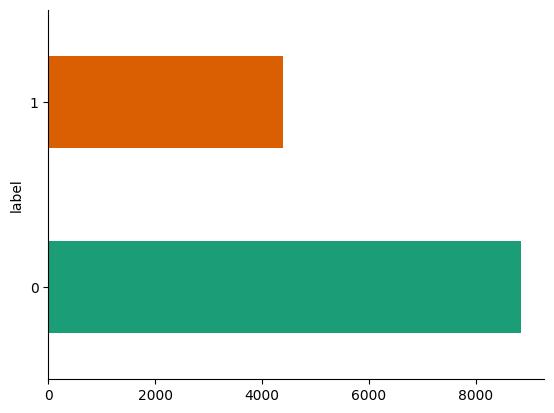

In [ ]:
df_target.groupby(['label']).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Train test

In [ ]:

df_target_tx,valid_target_texts,train_target_labels,valid_target_labels=train_test_split( df_target['tweet'],df_target['label'],test_size=0.35,stratify=df_target['label'])
print(f'Total size train set is :{len(df_target_tx)} \n')
print(f'Total size validation set is :{len(valid_target_texts)} \n')
train_texts_olid=df_target_tx.tolist()
train_labels_olid = train_target_labels.astype(int).tolist()

valid_texts_olid=valid_target_texts.tolist()
valid_labels_olid = valid_target_labels.astype(int).tolist()



Total size train set is :8606 

Total size validation set is :4634 



### Train Reberta model

In [ ]:
# roberta_model,roberta_tokenizer= load_roberta()

trainer_Re_OLID=train_reberta(train_texts_olid,train_labels_olid,valid_texts_olid,valid_labels_olid,roberta_model,roberta_tokenizer)


### Save trained Roberta model

In [ ]:
con_path_Re_Olid = '/content/drive/MyDrive/Uni/Aston/Dissertation/Reberta_epoch3_batch8_rate5_olid/'

trainer_Re_OLID.save_model(con_path_Re_Olid)


In [ ]:
trainer_Re_OLID.evaluate()

### Load trained model roberta

In [120]:
model_path = '/content/drive/MyDrive/ML/NLPResults/Reberta_epoch3_batch8_rate5_olid'#'/content/drive/MyDrive/Uni/Aston/Dissertation/Reberta_epoch3_batch8_rate5_olid'
#

def load_trained_Reberta(path):
  # Load the model
  re_model_ = AutoModelForSequenceClassification.from_pretrained(path)

  return re_model_



In [14]:
trainer_Re_OLID_=load_trained_Reberta(model_path)


### Test with the comments dataset

In [ ]:
df_test_with_token_1=data[data['rewire_id']=='sexism2022_english-10268']#data[(~(data['SHAP_value_token'].isna()))]
df_test_with_token_1

rewire_id  \
38  sexism2022_english-10268   

                                                 text label_sexist  \
38  yes, normal women want to be dominated. social...       sexist   

   label_category             label_vector split  \
38  2. derogation  2.1 descriptive attacks  test   

                                                token        target  \
38  normal women want to be dominated, Social scie...  normal women   

              keyword  bert_predicted_class  ...  \
38   female hypergamy                   1.0  ...   

                     SHAP_value_token SHAP_class0_prediction_token  \
38  ["", "normal ", "dominated ", ""]                     0.458906   

   SHAP_class1_prediction_token  lime_output_target  \
38                          0.0                None   

    lime_class0_predict_target lime_class1_predict_target  SHAP_value_target  \
38                         NaN                        NaN               None   

    SHAP_class0_prediction_target SHAP_class1_prediction_target  label  
38                           None                          None      1  

[1 rows x 25 columns]

In [ ]:

test_texts_2=df_test_with_token_1['text'].tolist()
test_labels_2 = df_test_with_token_1['label'].astype(int).tolist()


In [ ]:
# result = pd.concat([pd.DataFrame(test_texts_2), pd.DataFrame(probabilities)], axis=1)
# result.columns = ['text', '0', '1']
# result

text         0         1
0   leg day is easy. hot girls who wear miniskirt...  0.903660  0.096340
1  i get a new pussy every other week or whenever...  0.084677  0.915323
2  i agree with that but at the same time i know ...  0.800153  0.199847
3  o come on there's no way any men are attracted...  0.091280  0.908720
4  democrats from minnesota (leftist muzzie shith...  0.072358  0.927642

### Train bert model

In [ ]:
# def train_bert_model(train_texts,train_labels,valid_texts,valid_labels):
train_texts,train_labels,valid_texts,valid_labels=train_texts_olid, train_labels_olid, valid_texts_olid, valid_labels_olid
tokenizer = BertTokenizerFast.from_pretrained(bert_model_name, do_lower_case=True)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
train_dataset = CustomDataset(train_encodings, train_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_encodings = tokenizer(valid_texts, truncation=True, padding=True, return_tensors='pt', max_length=max_length)
test_dataset = CustomDataset(test_encodings, valid_labels)

model=BertForSequenceClassification.from_pretrained(bert_model_name)
training_args = TrainingArguments(
  output_dir='/content/output',
  num_train_epochs=10,
  per_device_train_batch_size=16,  # batch size
  weight_decay=0.01,               # strength of weight decay
  load_best_model_at_end=True,
  logging_steps=200,
  evaluation_strategy="steps",
  save_steps=400,  # a multiple of evaluation_steps
  # no_deprecation_warning=True
)
###


trainer = Trainer( model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,)
trainer.train()




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

TrainOutput(global_step=5380, training_loss=0.1551758332766565, metrics={'train_runtime': 4200.1202, 'train_samples_per_second': 20.49, 'train_steps_per_second': 1.281, 'total_flos': 7562520897562800.0, 'train_loss': 0.1551758332766565, 'epoch': 10.0})

In [ ]:
bert_con_path = '/content/drive/MyDrive/ML/NLPResults/BERT_epoch10_batchsize16_rate5e-5_OLID'

trainer.save_model(bert_con_path)

### **LIME explaination for Target predictions**

In [121]:
def wrapper_prediction_target(text):
  model_path = '/content/drive/MyDrive/Uni/Aston/Dissertation/Reberta_epoch3_batch8_rate5_olid/'

  return re_model_predict(text,model_path)



def verify_target_by_LIMe(test_data: pd.DataFrame, row_count=None,path=''):
  # m_ = pipeline("text-classification", model=re_model_, tokenizer=re_tokenizer)
  # explainer_ = shap.Explainer(m_)
  explainer_ = LimeTextExplainer()
  if row_count:
    df_=test_data[:row_count].copy()
  else:
    df_=  test_data.copy()
  for ind, row_test in df_.iterrows():
      tst = preprocess_text( row_test['text'])
      sexist_targets = row_test['target']
      res_LIMe=get_LIMe_interpretation(tst,explainer_,path)
      re_LIME_proba=re_model_predict(tst,path)

      correct_result_LIMe,sorted_token_score_pairs_ ,ratio_LIMe_detection=report_correct_LIMe_explanation(res_LIMe, sexist_targets)

      print(f'"{sexist_targets}" are targets in the following comment:\n "{tst}" ')
      print(f'\nLIME algorithm detected: {correct_result_LIMe}')
      print(f'\nRatio correct explanation: {ratio_LIMe_detection}')
      # insert process


      df_.at[ind, 'lime_class1_predict_target'] = re_LIME_proba[0, 1].item()
      df_.at[ind, 'lime_class0_predict_target'] = re_LIME_proba[0, 0].item()
      df_.at[ind, 'lime_output_target'] = str(sorted_token_score_pairs_)
  return df_

In [122]:
def update_LIME_target_result(df:pd.DataFrame):
  # result=False
  try:
    util_store=Data_storage(conn_spec=d)
    conn=util_store.connector()
    col_list = {'lime_class1_predict_target':'float', 'lime_class0_predict_target':'float',
                'lime_output_target':'json'}
    util_store.update_columns_ex(df,col_list)
    print('Updated successfully')
    return True

  except Exception as e:

      print(f'Error in update:',e)
      return False

def get_LIME_target(df:pd.DataFrame):
  r=True
  for i , c in df.iterrows():
    model_path ='/content/drive/MyDrive/ML/NLPResults/Reberta_epoch3_batch8_rate5_olid'# '/content/drive/MyDrive/Uni/Aston/Dissertation/Reberta_epoch3_batch8_rate5_olid/'

    df_result= verify_target_by_LIMe(pd.DataFrame([c]),row_count=1,path=model_path)
    r=update_LIME_target_result(df_result)
    if not r:
      break



In [ ]:
get_LIME_target(df_test_with_token_)


In [ ]:
# df_target_LIME=verify_target_by_LIMe(df_test_with_token[1:2],row_count=1,path=model_path)
# test_data_by_LIMe(test_texts_2,model_path):
# df_result_LIME_target=df_target_LIME[['lime_class1_predict_target', 'lime_class0_predict_target', 'lime_output_target'] ]

#### update LIME target output in database

In [ ]:
# util_store=Data_storage(conn_spec=d)
# conn=util_store.connector()
# col_list = {'lime_class1_predict_target':'float', 'lime_class0_predict_target':'float',
#             'lime_output_target':'json'}
# util_store.update_columns_ex(df_target_LIME,col_list)

## **SHAP explaination for Target predictions**

#### SHAP with Reberta

In [123]:
def get_SHAP_interpretation_(text,explainer=None,re_model_=None, re_tokenizer=None):
  if( not explainer):
  # Initialize the SHAP explainer
    if (re_model_ ) and (re_tokenizer):
      m_ = pipeline("text-classification", model=re_model_, tokenizer=re_tokenizer)
      explainer = shap.Explainer(m_)
    else:
      raise Exception("when explainer is not defined the model and tokenizer should be set")


  # Generate SHAP values for the current instance
  shap_values = explainer([text])

  # Summarize SHAP values
  class_0_contributions = np.sum(shap_values[:, :, 0].values[0], axis=0)
  class_1_contributions = np.sum(shap_values[:, :, 1].values[0], axis=0)


  print("\n Class 0 contributions:", class_0_contributions)
  print("\n Class 1 contributions:", class_1_contributions)

  # Identify tokens with positive and negative contributions
  sexist_tokens, non_sexist_tokens = [], []
  for token, values in zip(shap_values.data[0], shap_values.values[0]):
      if abs(values[0]) > abs(values[1]):
          non_sexist_tokens.append(token)
      else:
          sexist_tokens.append(token)
  print(f'sexist token detected by SHAP:{sexist_tokens}')

  return non_sexist_tokens,sexist_tokens,shap_values,class_0_contributions,class_1_contributions

def report_correct_SHAP_explanation_(listSHAP:list[str], testTokens:str):
  sexist_tokens=testTokens
  correct_result_shap = []
  for res in listSHAP:
    if res.strip() in sexist_tokens.split():
        correct_result_shap.append(res)
  ratio_shap_detection = len(correct_result_shap) / len(sexist_tokens.split())
  # print(f'"{sexist_tokens}" in the following comment: "{tst}" is sexist. ')
  print(f'SHAP algorithm detected: {correct_result_shap}')
  print(f'Ratio correct explanation: {ratio_shap_detection}')
  return correct_result_shap, ratio_shap_detection

def test_data_by_SHAP_(test_data: pd.DataFrame,re_model_=None,re_tokenizer=None):
  m_ = pipeline("text-classification", model=re_model_, tokenizer=re_tokenizer)
  explainer_ = shap.Explainer(m_)
  df_=test_data
  for ind, row_test in test_data.iterrows():
      tst = row_test['text']
      tokens_ = row_test['target']
      non_sexist_tokens,sexist_tokens_SHAP,v_,proba0,proba1=get_SHAP_interpretation_(tst,explainer_)

      correct_result_shap, ratio_shap_detection=report_correct_SHAP_explanation_(sexist_tokens_SHAP,tokens_)

      print(f'"{tokens_}" in the following comment: "{tst}" is sexist. ')
      print(f'SHAP algorithm detected: {correct_result_shap}')
      print(f'Ratio correct explanation: {ratio_shap_detection}')
      print('**************')
      ##   insert_result(session, tst, str(lime_explanation), str(shap_values))

      df_.at[ind, 'SHAP_class1_prediction_target'] = proba1
      df_.at[ind, 'SHAP_class0_prediction_target'] = proba0
      df_.at[ind, 'SHAP_value_target'] = str(sexist_tokens_SHAP)
      print(str(sexist_tokens_SHAP))
  return df_


In [ ]:

df_re_target=test_data_by_SHAP_(df_test_with_token,trainer_Re_OLID_,re_tokenizer)

In [124]:
def update_SHAP_target_result(df:pd.DataFrame):
  # result=False
  try:

    util_store=Data_storage(conn_spec=d)
    conn=util_store.connector()
    col_list = {'SHAP_class1_prediction_target':'float', 'SHAP_class0_prediction_target':'float',
                'SHAP_value_target':'json'}
    util_store.update_columns_ex(df,col_list)
    print('Updated successfully')
    return True

  except Exception as e:

      print(f'Error in update:',e)
      return False


def get_SHAP_target(df:pd.DataFrame,trainer_Re_OLID_,re_tokenizer):
  r=True
  for i , c in df.iterrows():
    # print('Starting LIME on :',c)
    df_result=test_data_by_SHAP_(pd.DataFrame([c]),trainer_Re_OLID_,re_tokenizer)
    r=update_SHAP_target_result(df_result)
    if not r:
      break



In [ ]:
get_SHAP_target(df_test_with_token[11:],trainer_Re_OLID_,re_tokenizer)


#### update explanation output SHAP for target prediction in database

In [ ]:
util_store=Data_storage(conn_spec=d)
conn=util_store.connector()
col_list = {'SHAP_class1_prediction_target':'float', 'SHAP_class0_prediction_target':'float',
            'SHAP_value_target':'json'}
util_store.update_columns_ex(df_re_target,col_list)

NameError: ignored

#### TEST

In [ ]:
# roberta_model_name = "roberta-large"
# trainer_Re_OLID_=load_trained_Reberta(model_path)
# re_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
# # verify_target_by_SHAP(df_test_with_token[:1],trainer_Re_OLID_,re_tokenizer)


In [ ]:
# trainer_Re_OLID_,re_tokenizer
roberta_model_name = "roberta-large"

re_tokenizer_ = RobertaTokenizer.from_pretrained(roberta_model_name)
m_ = pipeline("text-classification", model=trainer_Re_OLID_, tokenizer=re_tokenizer_)
explainer_ = shap.Explainer(m_)

for ind, row_test in df_test_with_token[1:3].iterrows():
    tst = row_test['text']
    tokens_ = row_test['target']

    # if( not explainer):
    # Initialize the SHAP explainer
    if (trainer_Re_OLID_ ) and (re_tokenizer_):
      m_ = pipeline("text-classification", model=trainer_Re_OLID_, tokenizer=re_tokenizer_)
      explainer = shap.Explainer(m_)
    else:
      raise Exception("when explainer is not defined the model and tokenizer should be set")


    # Generate SHAP values for the current instance
    shap_values = explainer([tst])

    # Summarize SHAP values
    class_0_contributions = np.sum(shap_values[:, :, 0].values[0], axis=0)
    class_1_contributions = np.sum(shap_values[:, :, 1].values[0], axis=0)


    print("\n Class 0 contributions:", class_0_contributions)
    print("\n Class 1 contributions:", class_1_contributions)

    # Identify tokens with positive and negative contributions
    sexist_tokens, non_sexist_tokens = [], []
    for token, values in zip(shap_values.data[0], shap_values.values[0]):
        # if abs(values[0]) > abs(values[1]):
        if np.argmax(values) == 0:
            non_sexist_tokens.append(token.replace('Ġ', ''))
        else:
            sexist_tokens.append(token.replace('Ġ', ''))
    print(f'sexist token detected by SHAP:{sexist_tokens}')
    # return non_sexist_tokens,sexist_tokens,shap_values

    non_sexist_tokens,sexist_tokens_SHAP,v_=non_sexist_tokens,sexist_tokens,shap_values#get_SHAP_interpretation_(tst,explainer_)



  # **************
    sexist_tokens=tokens_
    correct_result_shap = []
    for res in sexist_tokens_SHAP:
      if res.strip() in sexist_tokens.split():
          correct_result_shap.append(res)
    ratio_shap_detection = len(correct_result_shap) / len(sexist_tokens.split())
    # print(f'"{sexist_tokens}" in the following comment: "{tst}" is sexist. ')
    print(f'SHAP algorithm detected: {correct_result_shap}')
    print(f'Ratio correct explanation: {ratio_shap_detection}')
    # return correct_result_shap, ratio_shap_detection

    # correct_result_shap, ratio_shap_detection= report_correct_SHAP_explanation_(sexist_tokens_SHAP,tokens_)

    print(f'"{tokens_}" in the following comment: "{tst}" is sexist. ')
    print(f'SHAP algorithm detected: {correct_result_shap}')
    print(f'Ratio correct explanation: {ratio_shap_detection}')
    print('**************')


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:12, 732.02s/it]              



 Class 0 contributions: 0.05435329675674442

 Class 1 contributions: 0.0
sexist token detected by SHAP:['', ' i', ' pussy', ' every', ' whenever', ' really', ' .', ' didnt', ' have', ' either', ' from', ' videos', ' .', ' also', ' as', ' dont', ' get', ' laid', '']
SHAP algorithm detected: []
Ratio correct explanation: 0.0
"asian ladies, PUAs" in the following comment: "i get a new pussy every other week or whenever i want really. didnt have to learn how to either from youtube videos. also puas dont get laid. at best they get 5/10 asian ladies after spending years pretending to be something they aren't. its pathetic" is sexist. 
SHAP algorithm detected: []
Ratio correct explanation: 0.0
**************


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [12:15, 735.95s/it]              


 Class 0 contributions: 0.05500847101211548

 Class 1 contributions: 0.0
sexist token detected by SHAP:[' can', ' the', ' minute', ' she', ' begins', ' to', ' hit', ' the', ' wall', ' and', ' some', ' hotter', ' ,', ' ,', ' s', ' impulse', ' control']
SHAP algorithm detected: []
Ratio correct explanation: 0.0
"women " in the following comment: "i agree with that but at the same time i know myself well enough to say i can’t love a woman. the minute she begins to hit the wall and some hotter, younger women enters the picture, it’s time for impulse control because i’m going to want that." is sexist. 
SHAP algorithm detected: []
Ratio correct explanation: 0.0
**************


In [ ]:
df_test_with_token[:1]['target'].values[0]

'Hot girls'

In [ ]:

m_ = pipeline("text-classification", model=trainer_Re_OLID_, tokenizer=re_tokenizer)
explainer_ = shap.Explainer(m_)
tst = df_test_with_token[:1]['text'].values[0]
tokens_ = df_test_with_token[:1]['target'].values[0]
# non_sexist_tokens,sexist_tokens_SHAP,v_=get_SHAP_interpretation(tst,explainer_)


In [ ]:
explainer = shap.Explainer(m_)

shap_values = explainer([tst])

# Summarize SHAP values
class_0_contributions = np.sum(shap_values[:, :, 0].values[0], axis=0)
class_1_contributions = np.sum(shap_values[:, :, 1].values[0], axis=0)


print("Class 0 contributions:", class_0_contributions)
print("Class 1 contributions:", class_1_contributions)

# sorted_token_score_pairs = sorted(list_token, key=lambda x: x[1], reverse=True)

# # Identify tokens with positive and negative contributions
# sexist_tokens, non_sexist_tokens = [], []
# for token, values in zip(shap_values.data[0], shap_values.values[0]):
#     if abs(values[0]) > abs(values[1]):
#         non_sexist_tokens.append(token)
#     else:
#         sexist_tokens.append(token)
# print(f'sexist token detected by SHAP:{sexist_tokens}')

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:40, 280.05s/it]              

Class 0 contributions: -0.04952442646026611
Class 1 contributions: 0.0


In [ ]:

correct_result_shap, ratio_shap_detection=report_correct_SHAP_explanation(sexist_tokens_SHAP,tokens_)

print(f'"{tokens_}" in the following comment: "{tst}" is sexist. ')
print(f'SHAP algorithm detected: {correct_result_shap}')
print(f'Ratio correct explanation: {ratio_shap_detection}')

SHAP algorithm detected: []
Ratio correct explanation: 0.0
"Hot girls" in the following comment: " leg day is easy. hot girls who wear miniskirts get asked out." is sexist. 
SHAP algorithm detected: []
Ratio correct explanation: 0.0


#### SHAP with BERT

In [ ]:
con_path_BERT_OLID = '/content/drive/MyDrive/ML/NLPResults/BERT_epoch10_batchsize16_rate5e-5_OLID'

bert_model_olid = AutoModelForSequenceClassification.from_pretrained(con_path_BERT_OLID)
bert_tokenizer_olid = BertTokenizerFast.from_pretrained(bert_model_name, do_lower_case=True)


In [ ]:
df_test_with_token['text'].values

array([' leg day is easy. hot girls who wear miniskirts get asked out.',
       "i get a new pussy every other week or whenever i want really. didnt have to learn how to either from youtube videos. also puas dont get laid. at best they get 5/10 asian ladies after spending years pretending to be something they aren't. its pathetic",
       'i agree with that but at the same time i know myself well enough to say i can’t love a woman. the minute she begins to hit the wall and some hotter, younger women enters the picture, it’s time for impulse control because i’m going to want that.',
       "o come on there's no way any men are attracted to her shes a pig🙄",
       'democrats from minnesota (leftist muzzie shithole) are the dumbest anti-americans there are. klobuchar, one of the reps. is a dumb bitch who has a moronic position on the tax bill. fuck this stupid woman'],
      dtype=object)

In [ ]:

m_ = pipeline("text-classification", model=bert_model_olid, tokenizer=bert_tokenizer_olid)
explainer_ = shap.Explainer(m_)

for ind, row_test in df_test_with_token.iterrows():
    tst = row_test['text']
    tokens_ = row_test['target']

    # if( not explainer):
    # Initialize the SHAP explainer
    if (bert_model_olid ) and (bert_tokenizer_olid):
      m_ = pipeline("text-classification", model=bert_model_olid, tokenizer=bert_tokenizer_olid)
      explainer = shap.Explainer(m_)
    else:
      raise Exception("when explainer is not defined the model and tokenizer should be set")


    # Generate SHAP values for the current instance
    shap_values = explainer([tst])

    # Summarize SHAP values
    class_0_contributions = np.sum(shap_values[:, :, 0].values[0], axis=0)
    class_1_contributions = np.sum(shap_values[:, :, 1].values[0], axis=0)
    print("\n Model Summary:", m_.model.summary())
    model_prediction = m_([tst])
    print("\n Model Prediction:", model_prediction)
    print("\n Class 0 contributions:", class_0_contributions)
    print("\n Class 1 contributions:", class_1_contributions)

    # Identify tokens with positive and negative contributions
    sexist_tokens, non_sexist_tokens = [], []
    for token, values in zip(shap_values.data[0], shap_values.values[0]):
        # if abs(values[0]) > abs(values[1]):
        if np.argmax(values) == 0:
            non_sexist_tokens.append(token.replace('Ġ', ''))
        else:
            sexist_tokens.append(token.replace('Ġ', ''))
    print(f'\n sexist token detected by SHAP:{sexist_tokens}')
    # return non_sexist_tokens,sexist_tokens,shap_values

    non_sexist_tokens,sexist_tokens_SHAP,v_=non_sexist_tokens,sexist_tokens,shap_values#get_SHAP_interpretation_(tst,explainer_)



  # **************
    sexist_tokens=tokens_
    correct_result_shap = []
    for res in sexist_tokens_SHAP:
      if res.strip() in sexist_tokens.split():
          correct_result_shap.append(res)
    ratio_shap_detection = len(correct_result_shap) / len(sexist_tokens.split())
    # print(f'"{sexist_tokens}" in the following comment: "{tst}" is sexist. ')
    print(f'\n SHAP algorithm detected: {correct_result_shap}')
    print(f'\n Ratio correct explanation: {ratio_shap_detection}')
    # return correct_result_shap, ratio_shap_detection

    # correct_result_shap, ratio_shap_detection= report_correct_SHAP_explanation_(sexist_tokens_SHAP,tokens_)

    print(f'"{tokens_}" in the following comment: "{tst}" is sexist. ')
    print(f'\n SHAP algorithm detected: {correct_result_shap}')
    print(f'\n Ratio correct explanation: {ratio_shap_detection}')
    print('**************')


  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:31, 91.60s/it]               



 Class 0 contributions: 0.05195510387420654

 Class 1 contributions: 0.0
sexist token detected by SHAP:['leg ', 'who ', 'wear ', 'mini', 'ski', 'rts ', 'get ']
SHAP algorithm detected: []
Ratio correct explanation: 0.0
"Hot girls" in the following comment: " leg day is easy. hot girls who wear miniskirts get asked out." is sexist. 
SHAP algorithm detected: []
Ratio correct explanation: 0.0
**************


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:22, 142.99s/it]              



 Class 0 contributions: -0.8437340259552002

 Class 1 contributions: 0.8678123950958252
sexist token detected by SHAP:['i ', 'get ', 'a ', 'new ', 'pussy ', 'or ', '. ', 'didn', 't ', 'have ', 'to ', 'learn ', 'how ', 'pu', 'as ', 'don', 't ', 'get ', 'laid', 'they ', 'get ', 'pretending ', 'to ', 'be ', 'something ', 'they ', 'aren', 't', '. ', 'pathetic']
SHAP algorithm detected: []
Ratio correct explanation: 0.0
"asian ladies, PUAs" in the following comment: "i get a new pussy every other week or whenever i want really. didnt have to learn how to either from youtube videos. also puas dont get laid. at best they get 5/10 asian ladies after spending years pretending to be something they aren't. its pathetic" is sexist. 
SHAP algorithm detected: []
Ratio correct explanation: 0.0
**************


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:15, 135.58s/it]              



 Class 0 contributions: 0.05468845367431641

 Class 1 contributions: 0.0
sexist token detected by SHAP:['but ', 'at ', 'the ', 't ', 'to ', 'hit ', 'the ', 'wall ', 'some ', 'hotter', ', ', 'younger ', 'women ', 'for ', 'impulse ', 'control ', 'because ', '']
SHAP algorithm detected: ['women ']
Ratio correct explanation: 1.0
"women " in the following comment: "i agree with that but at the same time i know myself well enough to say i can’t love a woman. the minute she begins to hit the wall and some hotter, younger women enters the picture, it’s time for impulse control because i’m going to want that." is sexist. 
SHAP algorithm detected: ['women ']
Ratio correct explanation: 1.0
**************


  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:41, 41.91s/it]               



 Class 0 contributions: -0.006835281848907471

 Class 1 contributions: 0.0
sexist token detected by SHAP:['o ', 'come ', 'no ', 'any ', 'men ', 's ', 'a ', 'pig🙄']
SHAP algorithm detected: []
Ratio correct explanation: 0.0
"she" in the following comment: "o come on there's no way any men are attracted to her shes a pig🙄" is sexist. 
SHAP algorithm detected: []
Ratio correct explanation: 0.0
**************


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:49, 109.12s/it]              


 Class 0 contributions: -0.8449814319610596

 Class 1 contributions: 0.9310022592544556
sexist token detected by SHAP:['', 'leftist ', 'shit', 'hole', 'are ', 'the ', 'dumb', 'est ', '-', 'is ', 'a ', 'dumb ', 'bitch ', 'who ', 'has ', 'a ', 'mor', 'onic ', 'position ', 'on ', 'fuck ', 'stupid ', 'woman', '']
SHAP algorithm detected: ['stupid ', 'woman']
Ratio correct explanation: 0.5
"Klobuchar, this stupid woman" in the following comment: "democrats from minnesota (leftist muzzie shithole) are the dumbest anti-americans there are. klobuchar, one of the reps. is a dumb bitch who has a moronic position on the tax bill. fuck this stupid woman" is sexist. 
SHAP algorithm detected: ['stupid ', 'woman']
Ratio correct explanation: 0.5
**************


## Detection ratio

### Report detection ratio

In [173]:
df_test_with_token_1=data[(~data['token'].isna()) & (data['token'] != 'none')& (data['token'] != '_') & (~data['lime_output_target'].isna()) & (~data['lime_output_token'].isna())]#.head(10)
print(len(df_test_with_token_1))
df_test_with_token_1[['lime_output_target','lime_output_token','SHAP_value_target','SHAP_value_token']].head(3)

59


lime_output_target  \
6  [("girls", 0.1252397645489515), ("hot", 0.1078...   
8  [("pussy", 0.9036263795350487), ("ladies", 0.0...   
9  [("woman", 0.16842243328707587), ("control", 0...   

                                   lime_output_token  \
6  [("girls", 0.12208834586769915), ("hot", 0.108...   
8  [("pussy", 0.9108433238053771), ("ladies", 0.0...   
9  [("woman", 0.1687521567054556), ("control", 0....   

                                   SHAP_value_target  \
6                                          [" ", ""]   
8  ["get ", "a ", "new ", "pussy ", "every ", "ot...   
9                                               [""]   

                                    SHAP_value_token  
6  ["", "leg ", "easy ", "wear ", "mini", "get ",...  
8    ["", "week ", "asian ", "years ", "something "]  
9  ["", "time ", "enough ", "minute ", "younger "...

In [205]:



def report_detection_ration(j:pd.DataFrame):
  for c, ro in j.iterrows():

    print('\nLIME Report on', ro.at['rewire_id'],'... \n')

    sexist_tokens=ro.at['token']
    sexist_target=ro.at['target']
    list_target=ro.at['lime_output_target']
    list_token=ro.at['lime_output_token']
    # if(ro.at['SHAP_value_token']  is not None):
    #   list_token_SHAP = ast.literal_eval(ro.at['SHAP_value_token'])
    # else: break
    # if ro.at['SHAP_value_target'] is not None:
    #   list_target_SHAP = ast.literal_eval(ro.at['SHAP_value_target'])
    # else: break


    print(sexist_tokens)

    list_token=ast.literal_eval(list_token)
    list_target=ast.literal_eval(list_target)

    sorted_token_score_pairs = sorted(list_token, key=lambda x: x[1], reverse=True)
    sorted_target_score_pairs = sorted(list_target, key=lambda x: x[1], reverse=True)

    # Extract sorted tokens
    sexist_token_detected_LIME,correct_result_LIME_token,sexist_target_detected_LIME,correct_result_LIME_target=[],[],[],[]
    sexist_tokens=re.split(r'[ ,]+', sexist_tokens)
    print('\n sexist_tokens:',sexist_tokens)

    for pair in sorted_token_score_pairs:
      # if pair[1]>0:
        sexist_token_detected_LIME.append(pair[0])
        if pair[0].strip() in sexist_tokens:
          correct_result_LIME_token.append(pair[0].strip())
        # print(pair)
    ratio_LIME_token_detection = len(correct_result_LIME_token) / len(sexist_tokens)
    j.loc[c,'lime_tokens_count']=len(correct_result_LIME_token)
    j.loc[c,'True_count_tokens']=len(sexist_tokens)
    j.loc[c,'ratio_LIME_token_detection']=ratio_LIME_token_detection
    # Display the result
    print(f'Original Tokens:{correct_result_LIME_token}')
    print(f'Ratio of corrcet token detected :{ratio_LIME_token_detection}')


    ## LIME Target ratio
    sexist_target=re.split(r'[ ,]+', sexist_target)
    print('\n sexist_target:',sexist_target)
    for pair in sorted_target_score_pairs:
      # if pair[1]>0:
        sexist_target_detected_LIME.append(pair[0])
        if pair[0].strip() in sexist_target:
          correct_result_LIME_target.append(pair[0].strip())
        # print(pair)
    ratio_LIME_target_detection = len(correct_result_LIME_target) / len(sexist_target)
    j.loc[c,'lime_target_count']=len(correct_result_LIME_target)
    j.loc[c,'True_count_target']=len(sexist_target)
    j.loc[c,'ratio_LIME_target_detection']=ratio_LIME_target_detection

    # Display the result
    print(f'Original Tokens:{correct_result_LIME_target}')
    print(f'Ratio of corrcet target detected :{ratio_LIME_target_detection}')
    #########################################################
    print('\nSHAP Report on', ro.at['rewire_id'],'... \n')


    # sexist_tokens=ro.at['token']
    # sexist_target=ro.at['target']
    # list_target=ro.at['lime_output_target']
    # list_token=ro.at['lime_output_token']
    if(ro.at['SHAP_value_token']  is not None):
      list_token_SHAP = ast.literal_eval(ro.at['SHAP_value_token'])
    else: break
    if ro.at['SHAP_value_target'] is not None:
      list_target_SHAP = ast.literal_eval(ro.at['SHAP_value_target'])
    else: break
    print(sexist_tokens)

    # list_token=ast.literal_eval(list_token)
    # list_target=ast.literal_eval(list_target)
    list_token_SHAP=[item.strip() for item in list_token_SHAP if item.strip()]
    list_target_SHAP=[item.trim() for item in list_target_SHAP if item.strip()]

    # sorted_token_score_pairs = sorted(list_token, key=lambda x: x[1], reverse=True)
    # sorted_target_score_pairs = sorted(list_target, key=lambda x: x[1], reverse=True)

    # Extract sorted tokens
    sexist_token_detected_LIME,correct_result_LIME_token,sexist_target_detected_LIME,correct_result_LIME_target=[],[],[],[]
    sexist_token_detected_SHAP,correct_result_SHAP_token,sexist_target_detected_SHAP,correct_result_SHAP_target=[],[],[],[]

    sexist_tokens=re.split(r'[ ,]+', sexist_tokens)
    print('\n sexist_tokens:',sexist_tokens)

    ## SHAP Token
    # list_token_SHAP=re.split(r'[ ,]+', list_token_SHAP)
    print('\n sexist_tokens by SHAP:',list_token_SHAP)
    for stri in list_token_SHAP:
      # if pair[1]>0:
        sexist_token_detected_SHAP.append(stri)
        if stri.strip() in sexist_tokens:
          correct_result_SHAP_token.append(stri)
        # print(pair)
    ratio_shap_detection = len(correct_result_SHAP_token) / len(sexist_tokens)
    j.loc[c,'SHAP_token_count']=len(correct_result_SHAP_token)
    # j['True_count_target']=len(sexist_target)
    j.loc[c,'ratio_SHAP_token_detection']=ratio_shap_detection

    # Display the result
    print(f'Original SHAP Tokens:{correct_result_SHAP_token}')
    print(f'Ratio of corrcet SHAP toekn detected :{ratio_shap_detection}')

    ## SHAP Target sexist_target
    # list_token_SHAP=re.split(r'[ ,]+', list_token_SHAP)
    print('\n sexist_tokens:',sexist_target)
    print(f'the SHAP target {list_target_SHAP} and sexist true target {sexist_target}')
    for strin in list_target_SHAP:
      # if pair[1]>0:
        # sexist_target_detected_SHAP.append(strin)
        if strin.strip() in sexist_target:
          correct_result_SHAP_target.append(strin)
          print("correct_result_SHAP_target",correct_result_SHAP_target)
    ratio_SHAP_target_detection = len(correct_result_SHAP_target) / len(sexist_target)
    j.loc[c,'SHAP_target_count']=len(correct_result_SHAP_target)
    # j['True_count_target']=len(sexist_target)
    j.loc[c,'ratio_SHAP_target_detection']=ratio_SHAP_target_detection

    # Display the result
    print(f'Original SHAP Target:{correct_result_SHAP_target}')
    print(f'Ratio of corrcet target detected :{ratio_SHAP_target_detection}')
  return j




In [207]:


df_report_=report_detection_ration(df_test_with_token_1)

df_report_




LIME Report on sexism2022_english-7228 ... 

Hot girls who wear miniskirts

 sexist_tokens: ['Hot', 'girls', 'who', 'wear', 'miniskirts']
Original Tokens:['girls', 'wear', 'miniskirts']
Ratio of corrcet token detected :0.6

 sexist_target: ['Hot', 'girls']
Original Tokens:['girls']
Ratio of corrcet target detected :0.5

SHAP Report on sexism2022_english-7228 ... 

Hot girls who wear miniskirts

 sexist_tokens: ['Hot', 'girls', 'who', 'wear', 'miniskirts']

 sexist_tokens by SHAP: ['leg', 'easy', 'wear', 'mini', 'get', 'asked']
Original SHAP Tokens:['wear']
Ratio of corrcet SHAP toekn detected :0.2

 sexist_tokens: Hot girls
the SHAP target [''] and sexist true target Hot girls
correct_result_SHAP_target ['']
Original SHAP Target:['']
Ratio of corrcet target detected :0.1111111111111111

LIME Report on sexism2022_english-872 ... 

I get a new pussy, PUAs dont get laid

 sexist_tokens: ['I', 'get', 'a', 'new', 'pussy', 'PUAs', 'dont', 'get', 'laid']
Original Tokens:['pussy']
Ratio of co

rewire_id  \
6     sexism2022_english-7228   
8      sexism2022_english-872   
9     sexism2022_english-3553   
14   sexism2022_english-14992   
15   sexism2022_english-13328   
26    sexism2022_english-7260   
27    sexism2022_english-6629   
32    sexism2022_english-7022   
38   sexism2022_english-10268   
41   sexism2022_english-12319   
43    sexism2022_english-5581   
44   sexism2022_english-10735   
46    sexism2022_english-2771   
52   sexism2022_english-19849   
53   sexism2022_english-17938   
54    sexism2022_english-9987   
56   sexism2022_english-15676   
59    sexism2022_english-7290   
60   sexism2022_english-19501   
62   sexism2022_english-16366   
69    sexism2022_english-9087   
79    sexism2022_english-2964   
86   sexism2022_english-19341   
92    sexism2022_english-3048   
93   sexism2022_english-18377   
99     sexism2022_english-704   
103  sexism2022_english-11647   
104   sexism2022_english-8721   
115   sexism2022_english-7250   
117    sexism2022_english-949   
118  sexism2022_english-11296   
120   sexism2022_english-1860   
126  sexism2022_english-15860   
127  sexism2022_english-15696   
130   sexism2022_english-8476   
132   sexism2022_english-3673   
133  sexism2022_english-13224   
134  sexism2022_english-10924   
136  sexism2022_english-12662   
148  sexism2022_english-10666   
149  sexism2022_english-16284   
150  sexism2022_english-16799   
152  sexism2022_english-18155   
162  sexism2022_english-12531   
167   sexism2022_english-2204   
172  sexism2022_english-11830   
174  sexism2022_english-18981   
176  sexism2022_english-14081   
178   sexism2022_english-3312   
180  sexism2022_english-15543   
184   sexism2022_english-6549   
186  sexism2022_english-10558   
188   sexism2022_english-8853   
192  sexism2022_english-16394   
194   sexism2022_english-4766   
204   sexism2022_english-4996   
212   sexism2022_english-8826   
213   sexism2022_english-8459   
563   sexism2022_english-3734   

                                                  text label_sexist  \
6     leg day is easy. hot girls who wear miniskirt...       sexist   
8    i get a new pussy every other week or whenever...       sexist   
9    i agree with that but at the same time i know ...       sexist   
14   o come on there's no way any men are attracted...       sexist   
15   democrats from minnesota (leftist muzzie shith...       sexist   
26   former bbc journalist thuto mali says that uni...       sexist   
27   well then good because someone has to knock he...       sexist   
32   i did. you have to have the bravery to escalat...       sexist   
38   yes, normal women want to be dominated. social...       sexist   
41   not going to lie, the brutal honesty of this r...       sexist   
43   please.... take my wife, rape my daughter!! bu...       sexist   
44   she didn't have to be a bitch about it. she li...       sexist   
46   pink is very feminine so i accept this bikini ...       sexist   
52   yes. especially these days, it takes a lot to ...       sexist   
53   put a fork in muslim-england she's done for an...       sexist   
54   the she-god mentality of women is going down t...       sexist   
56            aim for the head so she dosn't come back       sexist   
59   the mediterranean countries are fucking hellho...       sexist   
60   just fucking lol. what does she know about a h...       sexist   
62   hahaha, why didnt you say that to my face you ...       sexist   
69                i would pay to see her ass cracker.        sexist   
79   i asked his dumbass why he fell for her. she h...       sexist   
86   hotter girls have higher bitch shields and shi...       sexist   
92   i wish they'd thrown the commie race traitor b...       sexist   
93        is that hitlery? looks like her hips and ass       sexist   
99   this guys gonna have a great time in the barra...       sexist   
103  she may be worth what someone paid for her in ...       sexist   
104  yeah, well, plenty of men have been hit by wom

In [204]:
df_report_[['rewire_id','text','token','target','lime_tokens_count','True_count_target','True_count_tokens','ratio_LIME_token_detection','lime_target_count','ratio_LIME_target_detection','SHAP_token_count','ratio_SHAP_token_detection','ratio_SHAP_target_detection','SHAP_target_count']]

rewire_id  \
6     sexism2022_english-7228   
8      sexism2022_english-872   
9     sexism2022_english-3553   
14   sexism2022_english-14992   
15   sexism2022_english-13328   
26    sexism2022_english-7260   
27    sexism2022_english-6629   
32    sexism2022_english-7022   
38   sexism2022_english-10268   
41   sexism2022_english-12319   
43    sexism2022_english-5581   
44   sexism2022_english-10735   
46    sexism2022_english-2771   
52   sexism2022_english-19849   
53   sexism2022_english-17938   
54    sexism2022_english-9987   
56   sexism2022_english-15676   
59    sexism2022_english-7290   
60   sexism2022_english-19501   
62   sexism2022_english-16366   
69    sexism2022_english-9087   
79    sexism2022_english-2964   
86   sexism2022_english-19341   
92    sexism2022_english-3048   
93   sexism2022_english-18377   
99     sexism2022_english-704   
103  sexism2022_english-11647   
104   sexism2022_english-8721   
115   sexism2022_english-7250   
117    sexism2022_english-949   
118  sexism2022_english-11296   
120   sexism2022_english-1860   
126  sexism2022_english-15860   
127  sexism2022_english-15696   
130   sexism2022_english-8476   
132   sexism2022_english-3673   
133  sexism2022_english-13224   
134  sexism2022_english-10924   
136  sexism2022_english-12662   
148  sexism2022_english-10666   
149  sexism2022_english-16284   
150  sexism2022_english-16799   
152  sexism2022_english-18155   
162  sexism2022_english-12531   
167   sexism2022_english-2204   
172  sexism2022_english-11830   
174  sexism2022_english-18981   
176  sexism2022_english-14081   
178   sexism2022_english-3312   
180  sexism2022_english-15543   
184   sexism2022_english-6549   
186  sexism2022_english-10558   
188   sexism2022_english-8853   
192  sexism2022_english-16394   
194   sexism2022_english-4766   
204   sexism2022_english-4996   
212   sexism2022_english-8826   
213   sexism2022_english-8459   
563   sexism2022_english-3734   

                                                  text  \
6     leg day is easy. hot girls who wear miniskirt...   
8    i get a new pussy every other week or whenever...   
9    i agree with that but at the same time i know ...   
14   o come on there's no way any men are attracted...   
15   democrats from minnesota (leftist muzzie shith...   
26   former bbc journalist thuto mali says that uni...   
27   well then good because someone has to knock he...   
32   i did. you have to have the bravery to escalat...   
38   yes, normal women want to be dominated. social...   
41   not going to lie, the brutal honesty of this r...   
43   please.... take my wife, rape my daughter!! bu...   
44   she didn't have to be a bitch about it. she li...   
46   pink is very feminine so i accept this bikini ...   
52   yes. especially these days, it takes a lot to ...   
53   put a fork in muslim-england she's done for an...   
54   the she-god mentality of women is going down t...   
56            aim for the head so she dosn't come back   
59   the mediterranean countries are fucking hellho...   
60   just fucking lol. what does she know about a h...   
62   hahaha, why didnt you say that to my face you ...   
69                i would pay to see her ass cracker.    
79   i asked his dumbass why he fell for her. she h...   
86   hotter girls have higher bitch shields and shi...   
92   i wish they'd thrown the commie race traitor b...   
93        is that hitlery? looks like her hips and ass   
99   this guys gonna have a great time in the barra...   
103  she may be worth what someone paid for her in ...   
104  yeah, well, plenty of men have been hit by wom...   
115  rot in hell bitch. you are a disgrace to aunti...   
117  lol that fat girl .... black men cant catch up...   
118  if you don't want your mother fucked, keep her...   
120  you don't praise women who act like cunts > >:...   
126  when i don't like a girl, who is not 'right' f...   
127              or women can stop being lying whores.   
130  yet 

In [203]:
df_report_[['rewire_id','text','token','target','lime_tokens_count','True_count_target','True_count_tokens','ratio_LIME_token_detection','lime_target_count','ratio_LIME_target_detection','SHAP_token_count','ratio_SHAP_token_detection','ratio_SHAP_target_detection','SHAP_target_count']]

rewire_id  \
6     sexism2022_english-7228   
8      sexism2022_english-872   
9     sexism2022_english-3553   
14   sexism2022_english-14992   
15   sexism2022_english-13328   
26    sexism2022_english-7260   
27    sexism2022_english-6629   
32    sexism2022_english-7022   
38   sexism2022_english-10268   
41   sexism2022_english-12319   
43    sexism2022_english-5581   
44   sexism2022_english-10735   
46    sexism2022_english-2771   
52   sexism2022_english-19849   
53   sexism2022_english-17938   
54    sexism2022_english-9987   
56   sexism2022_english-15676   
59    sexism2022_english-7290   
60   sexism2022_english-19501   
62   sexism2022_english-16366   
69    sexism2022_english-9087   
79    sexism2022_english-2964   
86   sexism2022_english-19341   
92    sexism2022_english-3048   
93   sexism2022_english-18377   
99     sexism2022_english-704   
103  sexism2022_english-11647   
104   sexism2022_english-8721   
115   sexism2022_english-7250   
117    sexism2022_english-949   
118  sexism2022_english-11296   
120   sexism2022_english-1860   
126  sexism2022_english-15860   
127  sexism2022_english-15696   
130   sexism2022_english-8476   
132   sexism2022_english-3673   
133  sexism2022_english-13224   
134  sexism2022_english-10924   
136  sexism2022_english-12662   
148  sexism2022_english-10666   
149  sexism2022_english-16284   
150  sexism2022_english-16799   
152  sexism2022_english-18155   
162  sexism2022_english-12531   
167   sexism2022_english-2204   
172  sexism2022_english-11830   
174  sexism2022_english-18981   
176  sexism2022_english-14081   
178   sexism2022_english-3312   
180  sexism2022_english-15543   
184   sexism2022_english-6549   
186  sexism2022_english-10558   
188   sexism2022_english-8853   
192  sexism2022_english-16394   
194   sexism2022_english-4766   
204   sexism2022_english-4996   
212   sexism2022_english-8826   
213   sexism2022_english-8459   
563   sexism2022_english-3734   

                                                  text  \
6     leg day is easy. hot girls who wear miniskirt...   
8    i get a new pussy every other week or whenever...   
9    i agree with that but at the same time i know ...   
14   o come on there's no way any men are attracted...   
15   democrats from minnesota (leftist muzzie shith...   
26   former bbc journalist thuto mali says that uni...   
27   well then good because someone has to knock he...   
32   i did. you have to have the bravery to escalat...   
38   yes, normal women want to be dominated. social...   
41   not going to lie, the brutal honesty of this r...   
43   please.... take my wife, rape my daughter!! bu...   
44   she didn't have to be a bitch about it. she li...   
46   pink is very feminine so i accept this bikini ...   
52   yes. especially these days, it takes a lot to ...   
53   put a fork in muslim-england she's done for an...   
54   the she-god mentality of women is going down t...   
56            aim for the head so she dosn't come back   
59   the mediterranean countries are fucking hellho...   
60   just fucking lol. what does she know about a h...   
62   hahaha, why didnt you say that to my face you ...   
69                i would pay to see her ass cracker.    
79   i asked his dumbass why he fell for her. she h...   
86   hotter girls have higher bitch shields and shi...   
92   i wish they'd thrown the commie race traitor b...   
93        is that hitlery? looks like her hips and ass   
99   this guys gonna have a great time in the barra...   
103  she may be worth what someone paid for her in ...   
104  yeah, well, plenty of men have been hit by wom...   
115  rot in hell bitch. you are a disgrace to aunti...   
117  lol that fat girl .... black men cant catch up...   
118  if you don't want your mother fucked, keep her...   
120  you don't praise women who act like cunts > >:...   
126  when i don't like a girl, who is not 'right' f...   
127              or women can stop being lying whores.   
130  yet 

### LIME

In [183]:
j=df_test_with_token_1.copy()

for c, ro in j.iterrows():
  print('\nLIME Report on', ro.at['rewire_id'],'... \n')

  sexist_tokens=ro.at['token']
  sexist_target=ro.at['target']
  list_target=ro.at['lime_output_target']
  list_token=ro.at['lime_output_token']
  # if(ro.at['SHAP_value_token']  is not None):
  #   list_token_SHAP = ast.literal_eval(ro.at['SHAP_value_token'])
  # else: break
  # if ro.at['SHAP_value_target'] is not None:
  #   list_target_SHAP = ast.literal_eval(ro.at['SHAP_value_target'])
  # else: break


  print(sexist_tokens)

  list_token=ast.literal_eval(list_token)
  list_target=ast.literal_eval(list_target)
  list_token_SHAP=[item.strip() for item in list_token_SHAP if item != ""]
  list_target_SHAP=[item.strip() for item in list_target_SHAP if item != ""]

  sorted_token_score_pairs = sorted(list_token, key=lambda x: x[1], reverse=True)
  sorted_target_score_pairs = sorted(list_target, key=lambda x: x[1], reverse=True)

  # Extract sorted tokens
  sexist_token_detected_LIME,correct_result_LIME_token,sexist_target_detected_LIME,correct_result_LIME_target=[],[],[],[]
  sexist_tokens=re.split(r'[ ,]+', sexist_tokens)
  print('\n sexist_tokens:',sexist_tokens)

  for pair in sorted_token_score_pairs:
    # if pair[1]>0:
      sexist_token_detected_LIME.append(pair[0])
      if pair[0].strip() in sexist_tokens:
        correct_result_LIME_token.append(pair[0].strip())
      # print(pair)
  ratio_LIME_token_detection = len(correct_result_LIME_token) / len(sexist_tokens)
  j.loc[c,'lime_tokens_count']=len(correct_result_LIME_token)
  j.loc[c,'True_count_tokens']=len(sexist_tokens)
  j.loc[c,'ratio_LIME_token_detection']=ratio_LIME_token_detection
  # Display the result
  print(f'Original Tokens:{correct_result_LIME_token}')
  print(f'Ratio of corrcet token detected :{ratio_LIME_token_detection}')


  ## LIME Target ratio
  sexist_target=re.split(r'[ ,]+', sexist_target)
  print('\n sexist_target:',sexist_target)
  for pair in sorted_target_score_pairs:
    # if pair[1]>0:
      sexist_target_detected_LIME.append(pair[0])
      if pair[0].strip() in sexist_target:
        correct_result_LIME_target.append(pair[0].strip())
      # print(pair)
  ratio_LIME_target_detection = len(correct_result_LIME_target) / len(sexist_target)
  j.loc[c,'lime_target_count']=len(correct_result_LIME_target)
  j.loc[c,'True_count_target']=len(sexist_target)
  j.loc[c,'ratio_LIME_target_detection']=ratio_LIME_target_detection

  # Display the result
  print(f'Original Tokens:{correct_result_LIME_target}')
  print(f'Ratio of corrcet target detected :{ratio_LIME_target_detection}')

j


LIME Report on sexism2022_english-7228 ... 

Hot girls who wear miniskirts

 sexist_tokens: ['Hot', 'girls', 'who', 'wear', 'miniskirts']
Original Tokens:['girls', 'wear', 'miniskirts']
Ratio of corrcet token detected :0.6

 sexist_target: ['Hot', 'girls']
Original Tokens:['girls']
Ratio of corrcet target detected :0.5

LIME Report on sexism2022_english-872 ... 

I get a new pussy, PUAs dont get laid

 sexist_tokens: ['I', 'get', 'a', 'new', 'pussy', 'PUAs', 'dont', 'get', 'laid']
Original Tokens:['pussy']
Ratio of corrcet token detected :0.1111111111111111

 sexist_target: ['asian', 'ladies', 'PUAs']
Original Tokens:['ladies', 'asian']
Ratio of corrcet target detected :0.6666666666666666

LIME Report on sexism2022_english-3553 ... 

I can't love a woman,  she begins to hit the wall

 sexist_tokens: ['I', "can't", 'love', 'a', 'woman', 'she', 'begins', 'to', 'hit', 'the', 'wall']
Original Tokens:['woman', 'begins', 'hit', 'love']
Ratio of corrcet token detected :0.36363636363636365

 

rewire_id  \
6     sexism2022_english-7228   
8      sexism2022_english-872   
9     sexism2022_english-3553   
14   sexism2022_english-14992   
15   sexism2022_english-13328   
26    sexism2022_english-7260   
27    sexism2022_english-6629   
32    sexism2022_english-7022   
38   sexism2022_english-10268   
41   sexism2022_english-12319   
43    sexism2022_english-5581   
44   sexism2022_english-10735   
46    sexism2022_english-2771   
52   sexism2022_english-19849   
53   sexism2022_english-17938   
54    sexism2022_english-9987   
56   sexism2022_english-15676   
59    sexism2022_english-7290   
60   sexism2022_english-19501   
62   sexism2022_english-16366   
69    sexism2022_english-9087   
79    sexism2022_english-2964   
86   sexism2022_english-19341   
92    sexism2022_english-3048   
93   sexism2022_english-18377   
99     sexism2022_english-704   
103  sexism2022_english-11647   
104   sexism2022_english-8721   
115   sexism2022_english-7250   
117    sexism2022_english-949   
118  sexism2022_english-11296   
120   sexism2022_english-1860   
126  sexism2022_english-15860   
127  sexism2022_english-15696   
130   sexism2022_english-8476   
132   sexism2022_english-3673   
133  sexism2022_english-13224   
134  sexism2022_english-10924   
136  sexism2022_english-12662   
148  sexism2022_english-10666   
149  sexism2022_english-16284   
150  sexism2022_english-16799   
152  sexism2022_english-18155   
162  sexism2022_english-12531   
167   sexism2022_english-2204   
172  sexism2022_english-11830   
174  sexism2022_english-18981   
176  sexism2022_english-14081   
178   sexism2022_english-3312   
180  sexism2022_english-15543   
184   sexism2022_english-6549   
186  sexism2022_english-10558   
188   sexism2022_english-8853   
192  sexism2022_english-16394   
194   sexism2022_english-4766   
204   sexism2022_english-4996   
212   sexism2022_english-8826   
213   sexism2022_english-8459   
563   sexism2022_english-3734   

                                                  text label_sexist  \
6     leg day is easy. hot girls who wear miniskirt...       sexist   
8    i get a new pussy every other week or whenever...       sexist   
9    i agree with that but at the same time i know ...       sexist   
14   o come on there's no way any men are attracted...       sexist   
15   democrats from minnesota (leftist muzzie shith...       sexist   
26   former bbc journalist thuto mali says that uni...       sexist   
27   well then good because someone has to knock he...       sexist   
32   i did. you have to have the bravery to escalat...       sexist   
38   yes, normal women want to be dominated. social...       sexist   
41   not going to lie, the brutal honesty of this r...       sexist   
43   please.... take my wife, rape my daughter!! bu...       sexist   
44   she didn't have to be a bitch about it. she li...       sexist   
46   pink is very feminine so i accept this bikini ...       sexist   
52   yes. especially these days, it takes a lot to ...       sexist   
53   put a fork in muslim-england she's done for an...       sexist   
54   the she-god mentality of women is going down t...       sexist   
56            aim for the head so she dosn't come back       sexist   
59   the mediterranean countries are fucking hellho...       sexist   
60   just fucking lol. what does she know about a h...       sexist   
62   hahaha, why didnt you say that to my face you ...       sexist   
69                i would pay to see her ass cracker.        sexist   
79   i asked his dumbass why he fell for her. she h...       sexist   
86   hotter girls have higher bitch shields and shi...       sexist   
92   i wish they'd thrown the commie race traitor b...       sexist   
93        is that hitlery? looks like her hips and ass       sexist   
99   this guys gonna have a great time in the barra...       sexist   
103  she may be worth what someone paid for her in ...       sexist   
104  yeah, well, plenty of men have been hit by wom

### SHAP

In [174]:
# j=df_test_with_token_1.copy()
for c, ro in j.iterrows():
  print('\nSHAP Report on', ro.at['rewire_id'],'... \n')


  sexist_tokens=ro.at['token']
  sexist_target=ro.at['target']
  # list_target=ro.at['lime_output_target']
  # list_token=ro.at['lime_output_token']
  if(ro.at['SHAP_value_token']  is not None):
    list_token_SHAP = ast.literal_eval(ro.at['SHAP_value_token'])
  else: break
  if ro.at['SHAP_value_target'] is not None:
    list_target_SHAP = ast.literal_eval(ro.at['SHAP_value_target'])
  else: break
  print(sexist_tokens)

  # list_token=ast.literal_eval(list_token)
  # list_target=ast.literal_eval(list_target)
  list_token_SHAP=[item.strip() for item in list_token_SHAP if item != ""]
  list_target_SHAP=[item.strip() for item in list_target_SHAP if item != ""]

  # sorted_token_score_pairs = sorted(list_token, key=lambda x: x[1], reverse=True)
  # sorted_target_score_pairs = sorted(list_target, key=lambda x: x[1], reverse=True)

  # Extract sorted tokens
  sexist_token_detected_LIME,correct_result_LIME_token,sexist_target_detected_LIME,correct_result_LIME_target=[],[],[],[]
  sexist_token_detected_SHAP,correct_result_SHAP_token,sexist_target_detected_SHAP,correct_result_SHAP_target=[],[],[],[]

  sexist_tokens=re.split(r'[ ,]+', sexist_tokens)
  print('\n sexist_tokens:',sexist_tokens)

  ## SHAP Token
  # list_token_SHAP=re.split(r'[ ,]+', list_token_SHAP)
  print('\n sexist_tokens by SHAP:',list_token_SHAP)
  for stri in list_token_SHAP:
    # if pair[1]>0:
      sexist_token_detected_SHAP.append(stri)
      if stri.strip() in sexist_tokens:
        correct_result_SHAP_token.append(stri)
      # print(pair)
  ratio_shap_detection = len(correct_result_SHAP_token) / len(sexist_tokens)
  j.loc[c,'SHAP_token_count']=len(correct_result_SHAP_token)
  # j['True_count_target']=len(sexist_target)
  j.loc[c,'ratio_SHAP_token_detection']=ratio_shap_detection

  # Display the result
  print(f'Original SHAP Tokens:{correct_result_SHAP_token}')
  print(f'Ratio of corrcet SHAP toekn detected :{ratio_shap_detection}')

  ## SHAP Target sexist_target
  # list_token_SHAP=re.split(r'[ ,]+', list_token_SHAP)
  print('\n sexist_tokens:',sexist_target)
  for strin in list_target_SHAP:
    # if pair[1]>0:
      sexist_target_detected_SHAP.append(strin)
      if strin.strip() in sexist_target:
        correct_result_SHAP_target.append(strin)
      # print(pair)
  ratio_SHAP_target_detection = len(correct_result_SHAP_target) / len(sexist_target)
  j.loc[c,'SHAP_target_count']=len(correct_result_SHAP_target)
  # j['True_count_target']=len(sexist_target)
  j.loc[c,'ratio_SHAP_target_detection']=ratio_SHAP_target_detection

  # Display the result
  print(f'Original SHAP Target:{correct_result_SHAP_target}')
  print(f'Ratio of corrcet target detected :{ratio_SHAP_target_detection}')



SHAP Report on sexism2022_english-7228 ... 

Hot girls who wear miniskirts

 sexist_tokens: ['Hot', 'girls', 'who', 'wear', 'miniskirts']

 sexist_tokens by SHAP: ['leg', 'easy', 'wear', 'mini', 'get', 'asked']
Original SHAP Tokens:['wear']
Ratio of corrcet SHAP toekn detected :0.2

 sexist_tokens: Hot girls
Original SHAP Target:['']
Ratio of corrcet target detected :0.1111111111111111

SHAP Report on sexism2022_english-872 ... 

I get a new pussy, PUAs dont get laid

 sexist_tokens: ['I', 'get', 'a', 'new', 'pussy', 'PUAs', 'dont', 'get', 'laid']

 sexist_tokens by SHAP: ['week', 'asian', 'years', 'something']
Original SHAP Tokens:[]
Ratio of corrcet SHAP toekn detected :0.0

 sexist_tokens: asian ladies, PUAs
Original SHAP Target:['a', 'as', 'ian', 'ladies']
Ratio of corrcet target detected :0.2222222222222222

SHAP Report on sexism2022_english-3553 ... 

I can't love a woman,  she begins to hit the wall

 sexist_tokens: ['I', "can't", 'love', 'a', 'woman', 'she', 'begins', 'to', 'h

### Visualization of results by SHAP and LIME

In [179]:
import plotly.express as px
def trim_rewire_id(rewire_id):
    # Find the index of "english-" in the string
    index = rewire_id.find("english-")

    # If "english-" is found, trim the string from that index to the end
    if index != -1:
        return rewire_id[index:]

    # If "english-" is not found, return the original string
    return rewire_id
j['trimmed_id'] = j['rewire_id'].apply(trim_rewire_id)



In [184]:

fig = px.bar(j, x="trimmed_id", y=["lime_tokens_count","SHAP_token_count","True_count_tokens"],  title="Total Tokens Comparison of LIME and SHAP ")
fig.update_layout(xaxis_title="Sentence Id", yaxis_title="Token Counts")

fig.show()


In [185]:
fig = px.bar(j, x="trimmed_id", y=["lime_target_count","SHAP_target_count","True_count_target"],  title="Total Target Comparison of LIME and SHAP ")
fig.update_layout(xaxis_title="Sentence Id", yaxis_title="Target Counts")

fig.show()

In [186]:
fig = px.line(j, x="trimmed_id", y=["ratio_LIME_token_detection","ratio_SHAP_token_detection"],  title="Token Detection of LIME and SHAP ")
fig.update_layout(xaxis_title="Sentence Id", yaxis_title="Correct Token Ratio")
fig.show()

In [187]:
fig = px.line(j, x="trimmed_id", y=["ratio_LIME_target_detection","ratio_SHAP_target_detection"],  title="Target Detection of LIME and SHAP ")
fig.update_layout(xaxis_title="Sentence Id", yaxis_title="Correct Target Ration")
# [['ratio_SHAP_target_detection','ratio_SHAP_token_detection','ratio_LIME_token_detection','ratio_LIME_target_detection']]
fig.show()

### aggregation analysis

A t-test indicates a statistically significant difference between the mean token detection ratios of LIME and SHAP (p-value < 0.05). LIME tends to have a higher average token detection ratio compared to SHAP.
Similarly, a t-test shows a statistically significant difference between the mean target detection ratios of LIME and SHAP (p-value < 0.05). LIME, on average, demonstrates better performance in identifying the correct targets.

In [202]:
from scipy.stats import ttest_ind

t_stat_to, p_value_to = ttest_ind(df_report_['lime_tokens_count'], df_report_['SHAP_token_count'])
t_stat_tar, p_value_tar = ttest_ind(df_report_['lime_target_count'], df_report_['SHAP_target_count'])

print(f"t-statistic: {t_stat_to}, p-value: {p_value_to}")

print(f"t-statistic: {t_stat_tar}, p-value: {p_value_tar}")


t-statistic: 8.265076702063647, p-value: 2.598869055272446e-13
t-statistic: -2.3118395192838483, p-value: 0.022551249452799894


In [201]:
from scipy.stats import ttest_rel

# Assuming your data is stored in a DataFrame called 'df'
t_stat_paired, p_value_paired = ttest_rel(df_report_['lime_tokens_count'], df_report_['True_count_tokens'])

# Display the paired t-statistic and p-value
print(f"Paired t-statistic: {t_stat_paired}, p-value: {p_value_paired}")


Paired t-statistic: -10.931073060066275, p-value: 1.0335090607112065e-15
